<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# TROLL HUNTING: DETECTING STATE-BACKED DISINFORMATION CAMPAIGNS ON TWITTER

## NOTEBOOK 2.0: EDA AND VISUALISATION

This notebook will be devoted to EDA and visualisation of various key aspects of real and state-backed tweets to see if we can find a "finger-print" for both. That is, are there clear characteristics that mark both sets?

I'll split the work according to 3 segments - timing (account creation/most active tweet period etc), "structural" characteristics of the tweets (length/use of hashtags etc), and content characteristics of the tweets.

I'm using several non-standard libraries (which have interactive features), so do install the following if you are planning to re-run this notebook:
- [Yellowbrick](https://www.scikit-yb.org/en/latest/quickstart.html)

- [pyLDAvis](https://pypi.org/project/pyLDAvis/)

- [Plotly](https://plot.ly/python/getting-started/)

In [1]:
import gensim
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import pyLDAvis.gensim
import scipy as sp
import seaborn as sns
import string

from collections import Counter, OrderedDict
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

init_notebook_mode(connected=True)

In [2]:
real = pd.read_csv('../data/real.csv')
state = pd.read_csv('../data/state.csv')

In [3]:
pd.set_option('display.max_columns', 25)

In [4]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
tweetid                        50000 non-null int64
user_screen_name               50000 non-null object
user_reported_location         50000 non-null object
user_profile_description       50000 non-null object
follower_count                 50000 non-null int64
following_count                50000 non-null int64
follower-to-following_ratio    50000 non-null float64
account_creation_date          50000 non-null object
year_of_account_creation       50000 non-null int64
month_of_account_creation      50000 non-null int64
tweet_time                     50000 non-null object
tweet_year                     50000 non-null int64
tweet_month                    50000 non-null int64
tweet_day                      50000 non-null int64
tweet_text                     50000 non-null object
clean_tweet_text               49655 non-null object
hashtags                       50000 non-null int6

In [5]:
# Looks like several hundred tweets are now blank due to earlier rounds of cleaning.
# This is likely due to the removal of emojis. I'll fill in the empty rows with generic "missing text"
real['clean_tweet_text'] = real['clean_tweet_text'].fillna('missing text')

In [6]:
real.describe(include='all')

tweetid user_screen_name user_reported_location  \
count   5.000000e+04            50000                  50000   
unique           NaN               35                     12   
top              NaN  realDonaldTrump          Washington DC   
freq             NaN             2504                  20848   
mean    1.029403e+18              NaN                    NaN   
std     1.506771e+17              NaN                    NaN   
min     1.574507e+17              NaN                    NaN   
25%     1.026753e+18              NaN                    NaN   
50%     1.093358e+18              NaN                    NaN   
75%     1.109711e+18              NaN                    NaN   
max     1.115266e+18              NaN                    NaN   

                              user_profile_description  follower_count  \
count                                            50000    5.000000e+04   
unique                                              35             NaN   
top     45th President of the United States of America             NaN   
freq                                              2504             NaN   
mean                                               NaN    1.447973e+07   
std                                                NaN    2.375733e+07   
min                                                NaN    2.831400e+04   
25%                                                NaN    9.104200e+05   
50%                                                NaN    3.008678e+06   
75%                                                NaN    2.034602e+07   
max                                                NaN    1.055208e+08   

        following_count  follower-to-following_ratio  \
count      50000.000000                 5.000000e+04   
unique              NaN                          NaN   
top                 NaN                          NaN   
freq                NaN                          NaN   
mean       27639.659400                 9.713087e+05   
std       115305.673331                 4.490593e+06   
min            1.000000                 4.840342e+00   
25%          362.000000                 2.775084e+02   
50%         1109.000000                 3.347326e+03   
75%         2097.000000                 1.878672e+04   
max       614870.000000                 2.364778e+07   

            account_creation_date  year_of_account_creation  \
count                       50000               50000.00000   
unique                         35                       NaN   
top     2009-03-18 13:46:38+00:00                       NaN   
freq                         2504                       NaN   
mean                          NaN                2008.81854   
std                           NaN                   1.95607   
min                           NaN                2007.00000   
25%                           NaN                2007.00000   
50%                           NaN                2009.00000   
75%                           NaN                2009.00000   
max                           NaN                2016.00000   

        month_of_account_creation           tweet_time    tweet_year  \
count                50000.000000                50000  50000.000000   
unique                        NaN                48682           NaN   
top                           NaN  2019-02-12 01:06:10           NaN   
freq                          NaN                    7           NaN   
mean                     5.022500                  NaN   2018.236100   
std                      2.905836                  NaN      1.251666   
min                      1.000000                  NaN   2012.000000   
25%                      3.000000                  NaN   2018.000000   
50%                      4.000000                  NaN   2019.000000   
75%                      8.000000                  NaN   2019.000000   
max                     11.000000                  NaN   2019.000000   

         tweet_month     tweet_day                 tweet_tex

In [7]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
tweetid                        50000 non-null int64
user_screen_name               50000 non-null object
user_reported_location         50000 non-null object
user_profile_description       50000 non-null object
follower_count                 50000 non-null int64
following_count                50000 non-null int64
follower-to-following_ratio    50000 non-null float64
account_creation_date          50000 non-null object
year_of_account_creation       50000 non-null int64
month_of_account_creation      50000 non-null int64
tweet_time                     50000 non-null object
tweet_year                     50000 non-null int64
tweet_month                    50000 non-null int64
tweet_day                      50000 non-null int64
tweet_text                     50000 non-null object
clean_tweet_text               50000 non-null object
hashtags                       50000 non-null int6

In [8]:
state.describe()

tweetid  follower_count  following_count  \
count  5.000000e+04    50000.000000     50000.000000   
mean   6.767213e+17    22554.531460      8621.452580   
std    1.161635e+17    20217.031331      8432.561764   
min    4.439983e+17        0.000000         0.000000   
25%    5.931123e+17     2748.000000      1038.000000   
50%    6.407312e+17    22823.000000      7904.000000   
75%    7.808538e+17    35988.000000     11010.000000   
max    9.975634e+17    72121.000000     50746.000000   

       follower-to-following_ratio  year_of_account_creation  \
count                 5.000000e+04              50000.000000   
mean                           inf               2014.185600   
std                            NaN                  0.736888   
min                   0.000000e+00               2009.000000   
25%                   1.689061e+00               2014.000000   
50%                   2.357865e+00               2014.000000   
75%                   3.342718e+00               2014.000000   
max                            inf               2018.000000   

       month_of_account_creation    tweet_year   tweet_month     tweet_day  \
count               50000.000000  50000.000000  50000.000000  50000.000000   
mean                    6.741520   2015.493760      6.042720     15.821320   
std                     2.145432      0.912194      3.312919      8.527591   
min                     1.000000   2014.000000      1.000000      1.000000   
25%                     5.000000   2015.000000      3.000000      9.000000   
50%                     6.000000   2015.000000      6.000000     16.000000   
75%                     8.000000   2016.000000      8.000000     23.000000   
max                    12.000000   2018.000000     12.000000     31.000000   

           hashtags        links         upper    char_count  \
count  50000.000000  50000.00000  50000.000000  50000.000000   
mean       0.725660      0.43906      0.407860     85.496700   
std        0.805438      0.72805      1.119739     34.245612   
min        0.000000      0.00000      0.000000      5.000000   
25%        0.000000      0.00000      0.000000     61.000000   
50%        1.000000      0.00000      0.000000     79.000000   
75%        1.000000      1.00000      1.000000    108.000000   
max       12.000000      3.00000     27.000000    627.000000   

       tweet_word_count  average_num_of_words  
count      50000.000000          50000.000000  
mean          12.092380              6.812286  
std            4.698958              4.870009  
min            1.000000              1.800000  
25%            9.000000              5.100000  
50%           11.000000              6.000000  
75%           14.000000              7.615385  
max           62.000000             81.500000

## 1. TIMING 
We intuitively know that these two sets of accounts are different, given that state-backed influence operations on Twitter are a relatively recent phenomenon. Let's see if the "time-stamp" of the activities by state-backed accounts left clear tell-tale signs.

## 1.1 ACCOUNT CREATION DATE

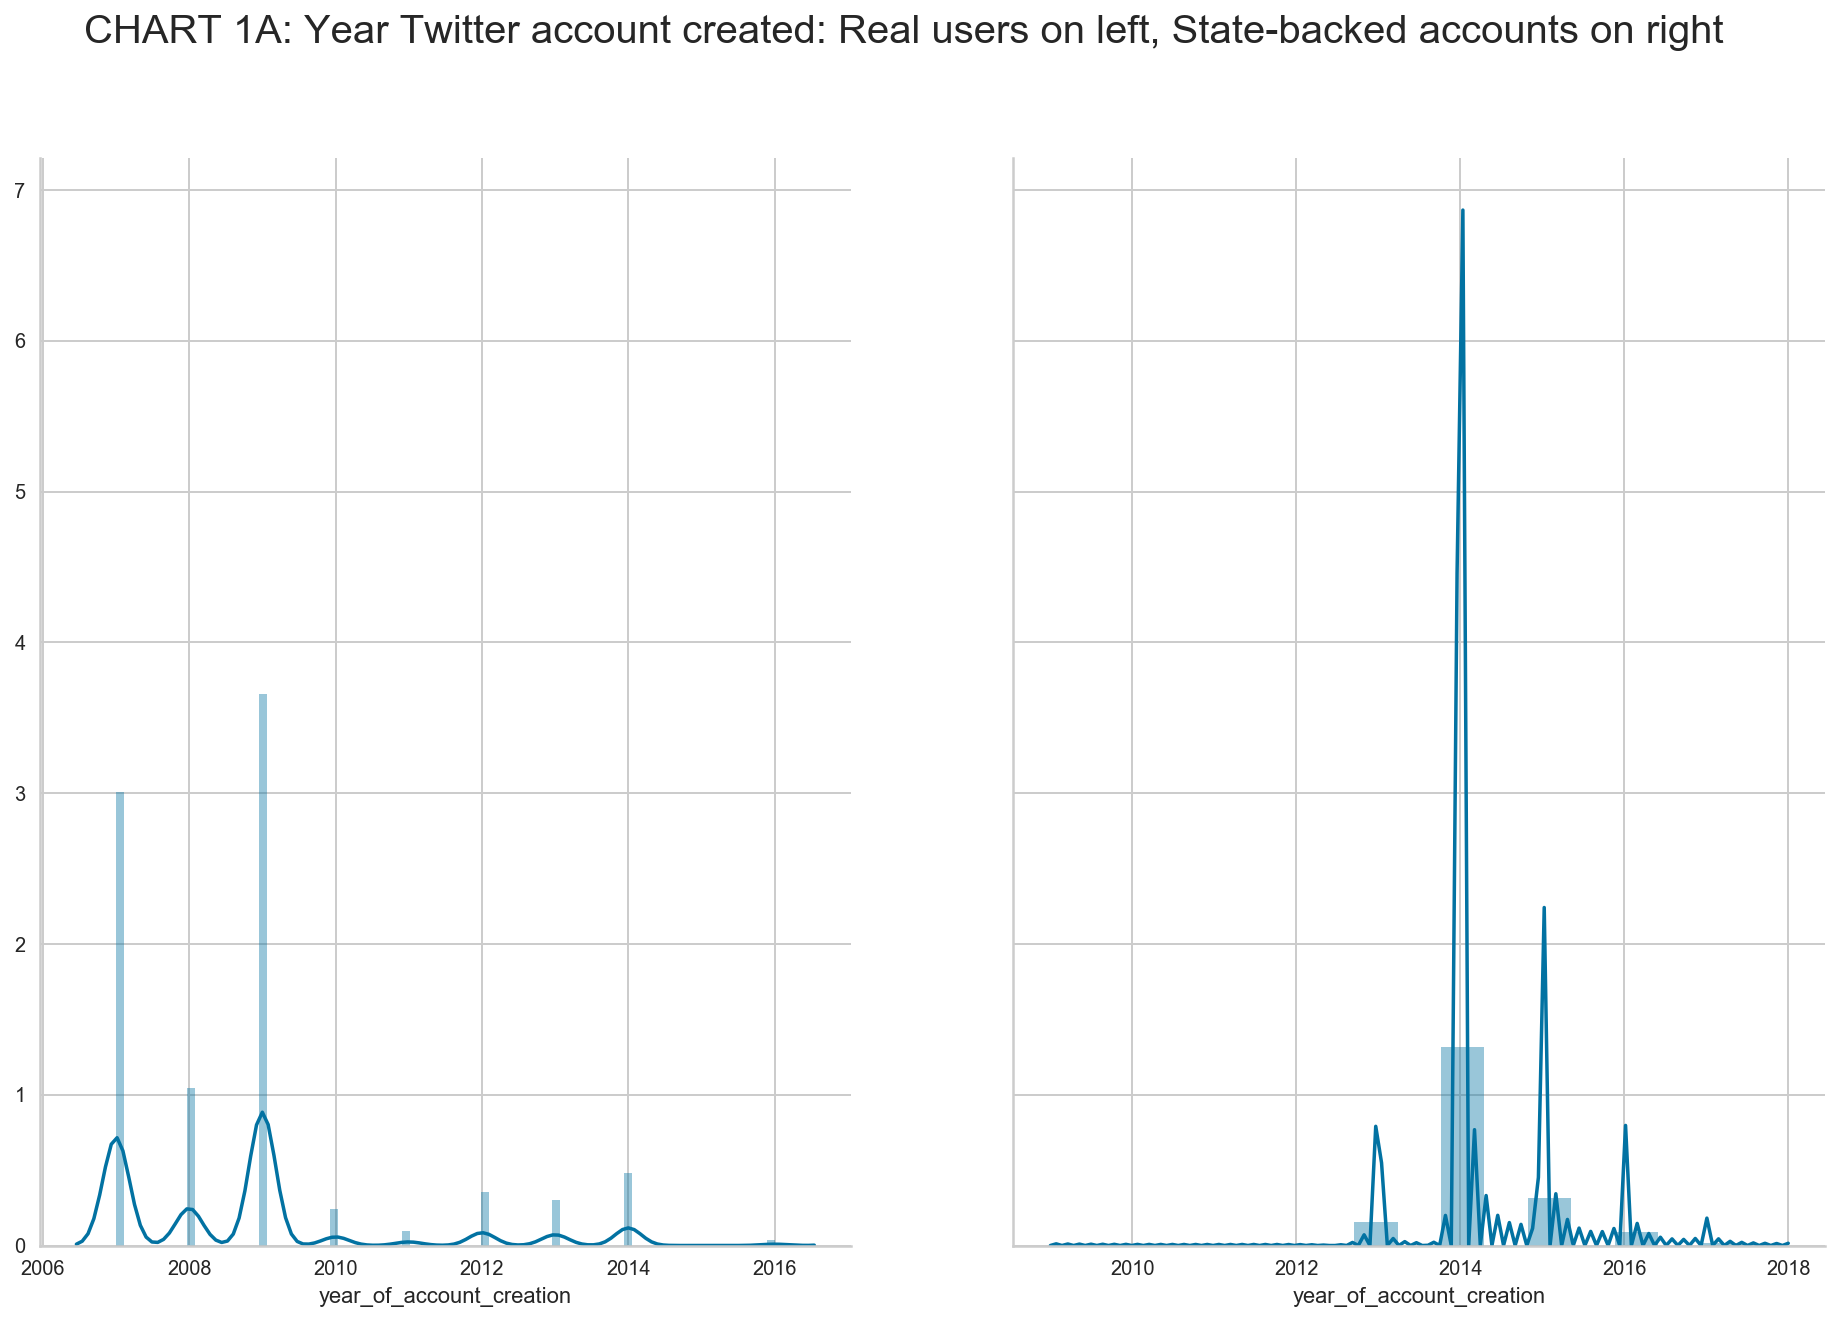

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
sns.distplot(real['year_of_account_creation'], bins='auto', ax=axs[0])
sns.distplot(state['year_of_account_creation'], bins='auto', ax=axs[1])
fig.suptitle(
    "CHART 1A: Year Twitter account created: Real users on left, State-backed accounts on right",
    fontsize=20,
)
sns.despine()
plt.show()

In [10]:
real['year_of_account_creation'].value_counts(normalize=True)

2009    0.39640
2007    0.32598
2008    0.11316
2014    0.05234
2012    0.03860
2013    0.03274
2010    0.02606
2011    0.01078
2016    0.00394
Name: year_of_account_creation, dtype: float64

In [11]:
state['year_of_account_creation'].value_counts(normalize=True)

2014    0.69530
2015    0.16564
2013    0.08216
2016    0.04584
2017    0.00806
2009    0.00286
2018    0.00014
Name: year_of_account_creation, dtype: float64

### The two charts clearly show the difference in this area - most of the state-operated accounts were created in 2014, while the majority of the real accounts in our dataset were created in 2007 and 2009. Let's take a closer look at the state-backed accounts created in 2014.

In [12]:
state_2014 = state[state['year_of_account_creation'] == 2014]

In [13]:
# in our dataset, 115 state-backed accounts were created in 2014
state_2014['user_screen_name'].nunique()

115

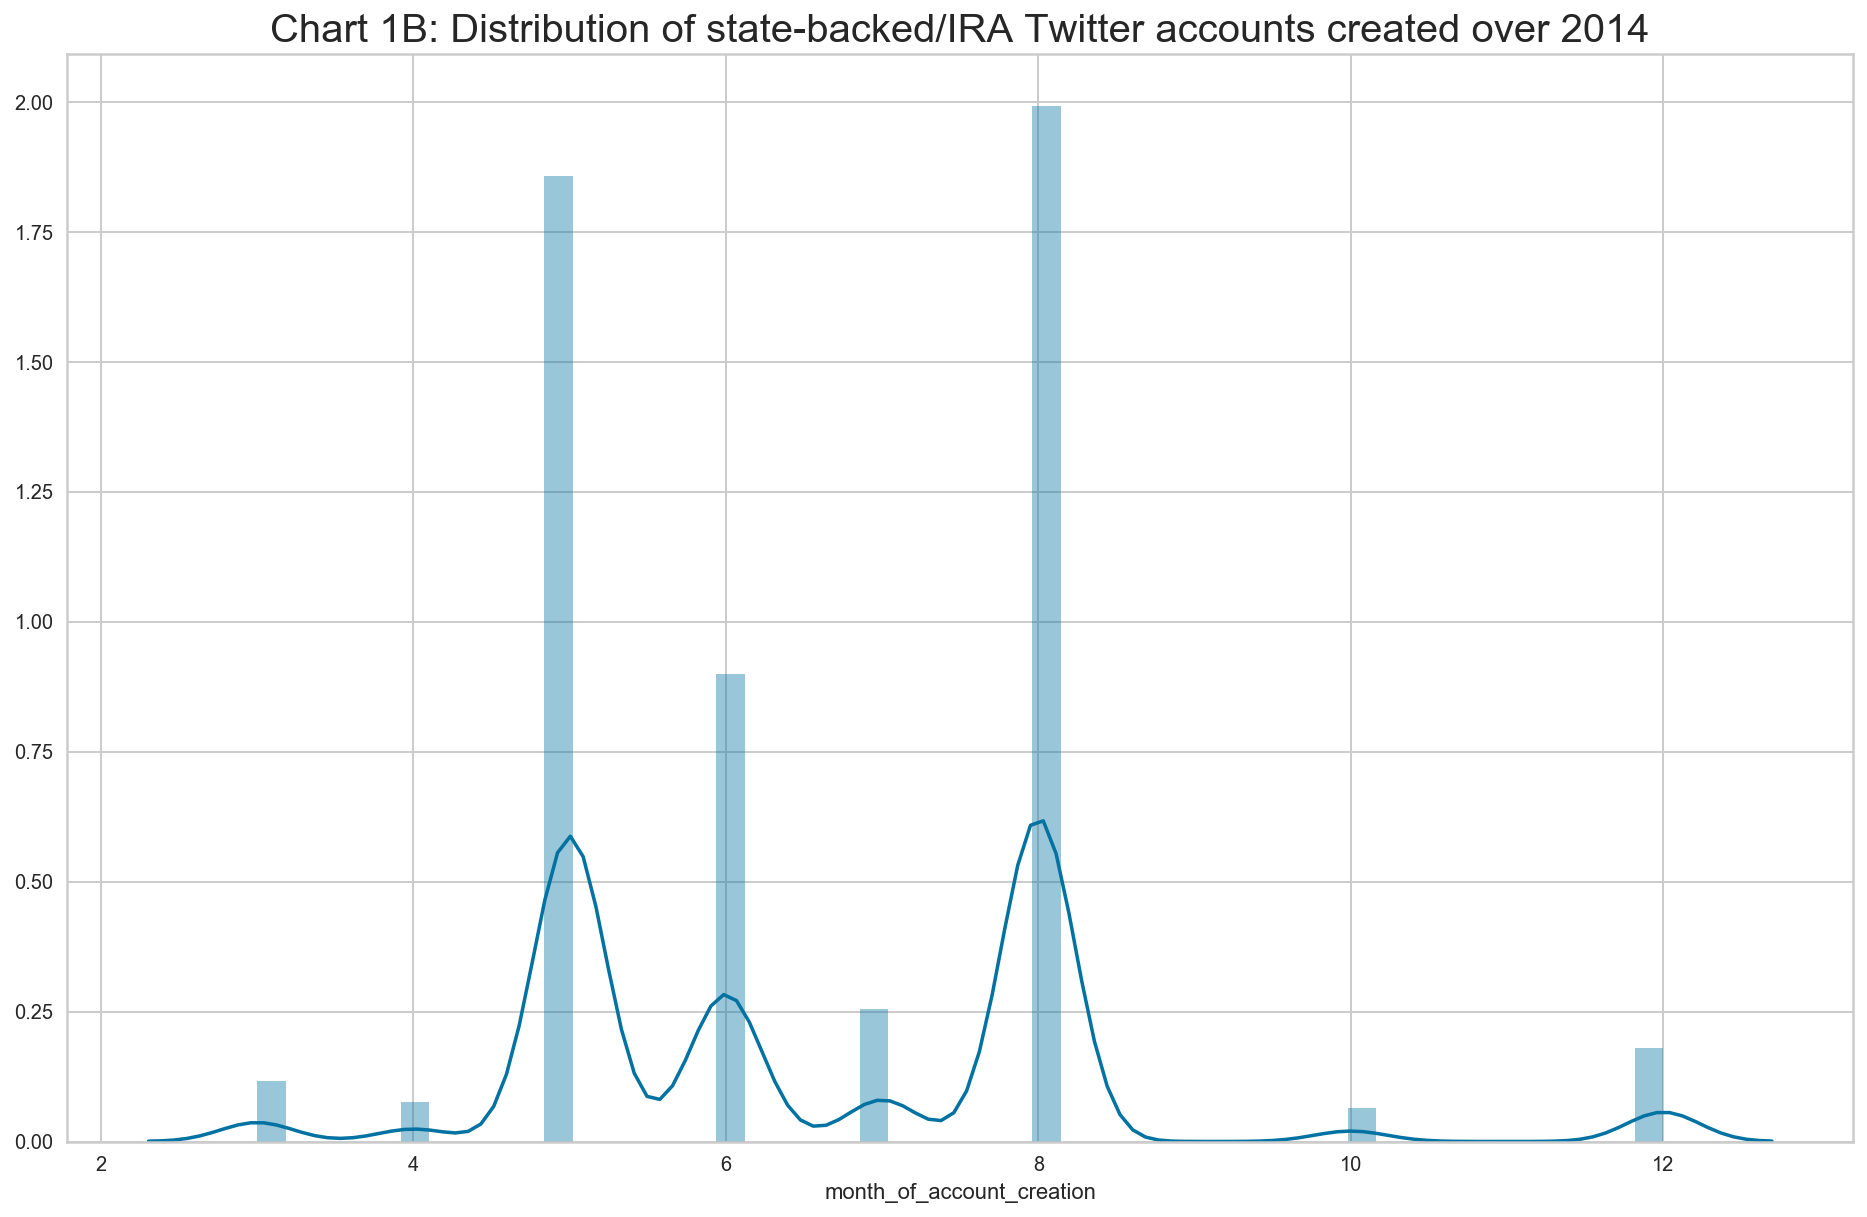

In [14]:
plt.figure(figsize=(16, 10))
sns.distplot(state_2014['month_of_account_creation'], bins='auto', hist=True)
plt.title('Chart 1B: Distribution of state-backed/IRA Twitter accounts created over 2014', fontsize=20)
plt.show()

In [15]:
state_2014['month_of_account_creation'].value_counts(normalize=True)

8     0.365943
5     0.341378
6     0.165339
7     0.046915
12    0.033223
3     0.021516
4     0.014008
10    0.011678
Name: month_of_account_creation, dtype: float64

### Most of the state-backed accounts created in 2014 were set up in May and August. This is consistent with [reports](https://www.vox.com/2018/2/16/17020974/mueller-indictment-internet-research-agency) on this issue which said the Kremlin-backed Internet Research Agency began its influence operations as early as 2014. 

### As such, year and month of account creation will certainly count as key aspects of a digital fingerprint for the state-backed accounts.

## 1.2 TIMING OF TWEETS
Aside from account creation, another key area to look is when the state-backed accounts were most active on Twitter. Was there a spike among state-backed accounts in the run up to the US election on November 2016?

In [16]:
state_tweets_distro = state[
    (state["tweet_year"] == 2014)
    | (state["tweet_year"] == 2015)
    | (state["tweet_year"] == 2016)
    | (state["tweet_year"] == 2017)
]

In [17]:
tweet_distro = go.Histogram(
    x=state_tweets_distro['tweet_year'],
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)
layout = go.Layout(
    title='Chart 2A: Distribution of state-backed/IRA tweets between 2014-2017',
    height=450,
    width=1200,
    xaxis=dict(
        title='Year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.3,
)

data = [tweet_distro]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [18]:
state['tweet_year'].value_counts()

2015    27287
2017     9947
2016     8470
2014     4141
2018      155
Name: tweet_year, dtype: int64

### Interestingly, the number of tweets by the state-backed operators peaked in 2015, though the number of tweets in 2016 was still high and they continued operating right through 2018. The sharp drop in number of tweets in 2018 likely reflects action taken by Twitter by then to clamp down on these accounts.

### Next, let's look specifically at the level of activity by these state-backed accounts in November 2016, the month where the US election between Donald Trump and Hillary Clinton was held.

In [19]:
state_tweets_2016 = state[(state["tweet_year"] == 2016) & (state["tweet_month"] == 11)]

In [20]:
tweets_nov2016 = go.Histogram(
    x=state_tweets_2016['tweet_day'],
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Chart 2B: Distribution of state-backed/IRA tweets on November 2016',
    height=450,
    width=1200,
    xaxis=dict(
        title='Day/November 2016'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [tweets_nov2016]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### As expected, the number of tweets in the election month by the state-backed accounts peaked on the 8th and 9th - the day of the election and its aftermath.

### NOTE:
It would be misleading to use my dataset to do a comparison of tweet activity between the real and fake accounts. This is because I only scraped the most recent 3,000+ plus tweets of every real account used in this project. In other words, I could get their real tweets only up to a point in time and could not precisely match the exact time frame of the real-Vs-fake tweets/accounts. That is one limitation of this project.

## 2. STRUCTURAL CHARACTERISTICS OF REAL VS STATE-BACKED TWEETS/ACCOUNTS
Next, let's look at how structurallyy different the real and state twitter accounts and their tweets are different from each other. 

## 2.1 FOLLOWERS-TO-FOLLOWING RATIO
We broadly know from media reports that these state-backed digital trolls have few followers, and instead follow a large number of real users in order to try to spread misinformation. Let's see if our dataset supports this widely-held assumption.

The followers-to-following ratio would be a key tell-tale sign, if this assertion is true.

In [21]:
follower_real = real.sort_values(by='follower_count', ascending=False)
follower_state = state.sort_values(by='follower_count', ascending=False)

In [22]:
following_real = real.sort_values(by='following_count', ascending=False)
following_state = state.sort_values(by='following_count', ascending=False)

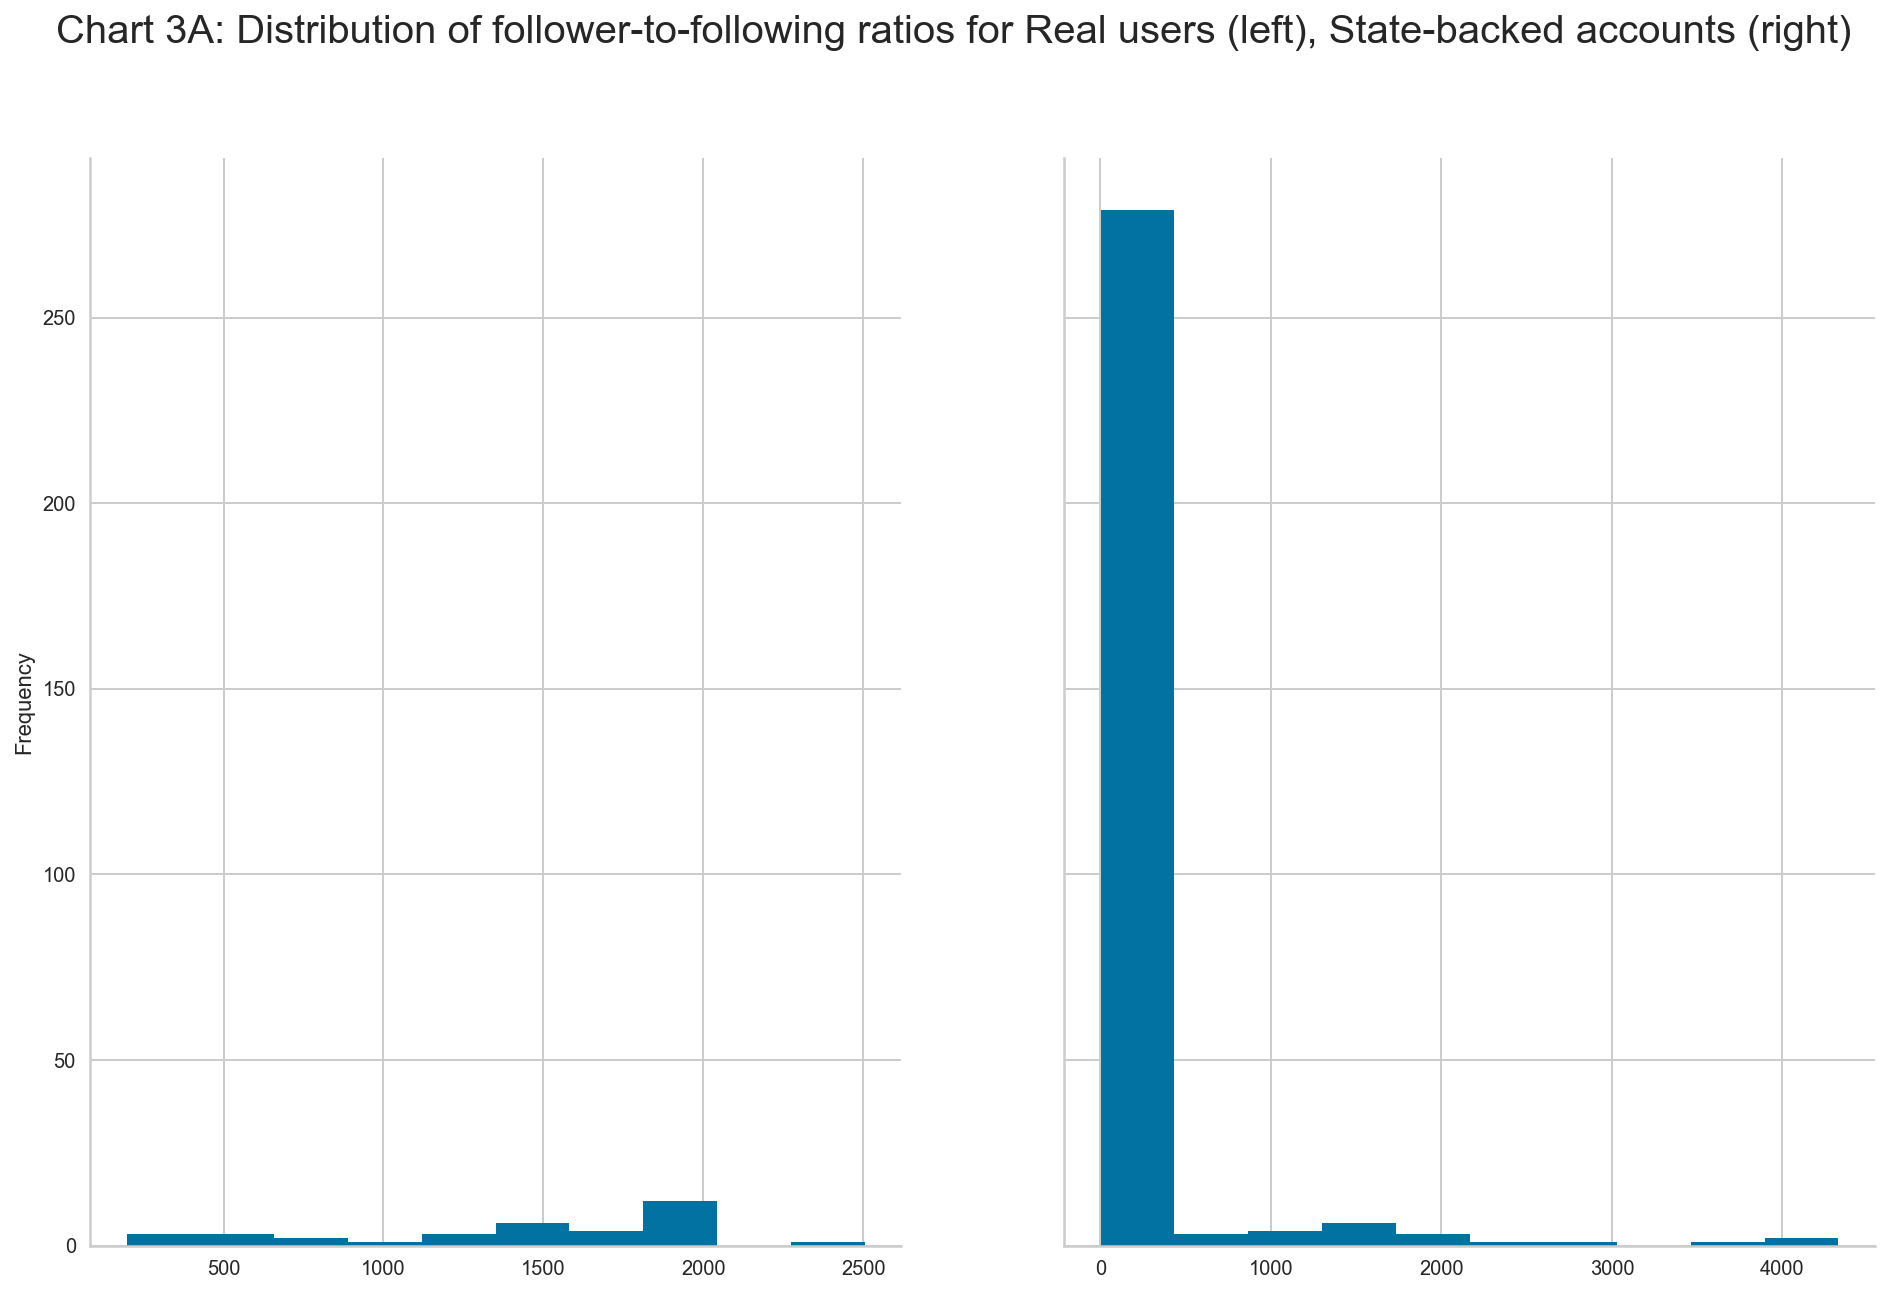

In [23]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['follower-to-following_ratio'].value_counts().plot.hist(ax=axs[0])
state['follower-to-following_ratio'].value_counts().plot.hist(ax=axs[1])
fig.suptitle(
    "Chart 3A: Distribution of follower-to-following ratios for Real users (left), State-backed accounts (right)",
    fontsize=20,
)
sns.despine()
plt.show()

### Chart 3A clearly shows the difference between the two camps, where state-backed accounts mostly have a near-zero or low follower-to-following ratio, meaning they mostly follow other real users and don't have many followers of their own. Real users have several magnitudes more followers than they do follow other accounts, as Chart 3B below shows clearly below.

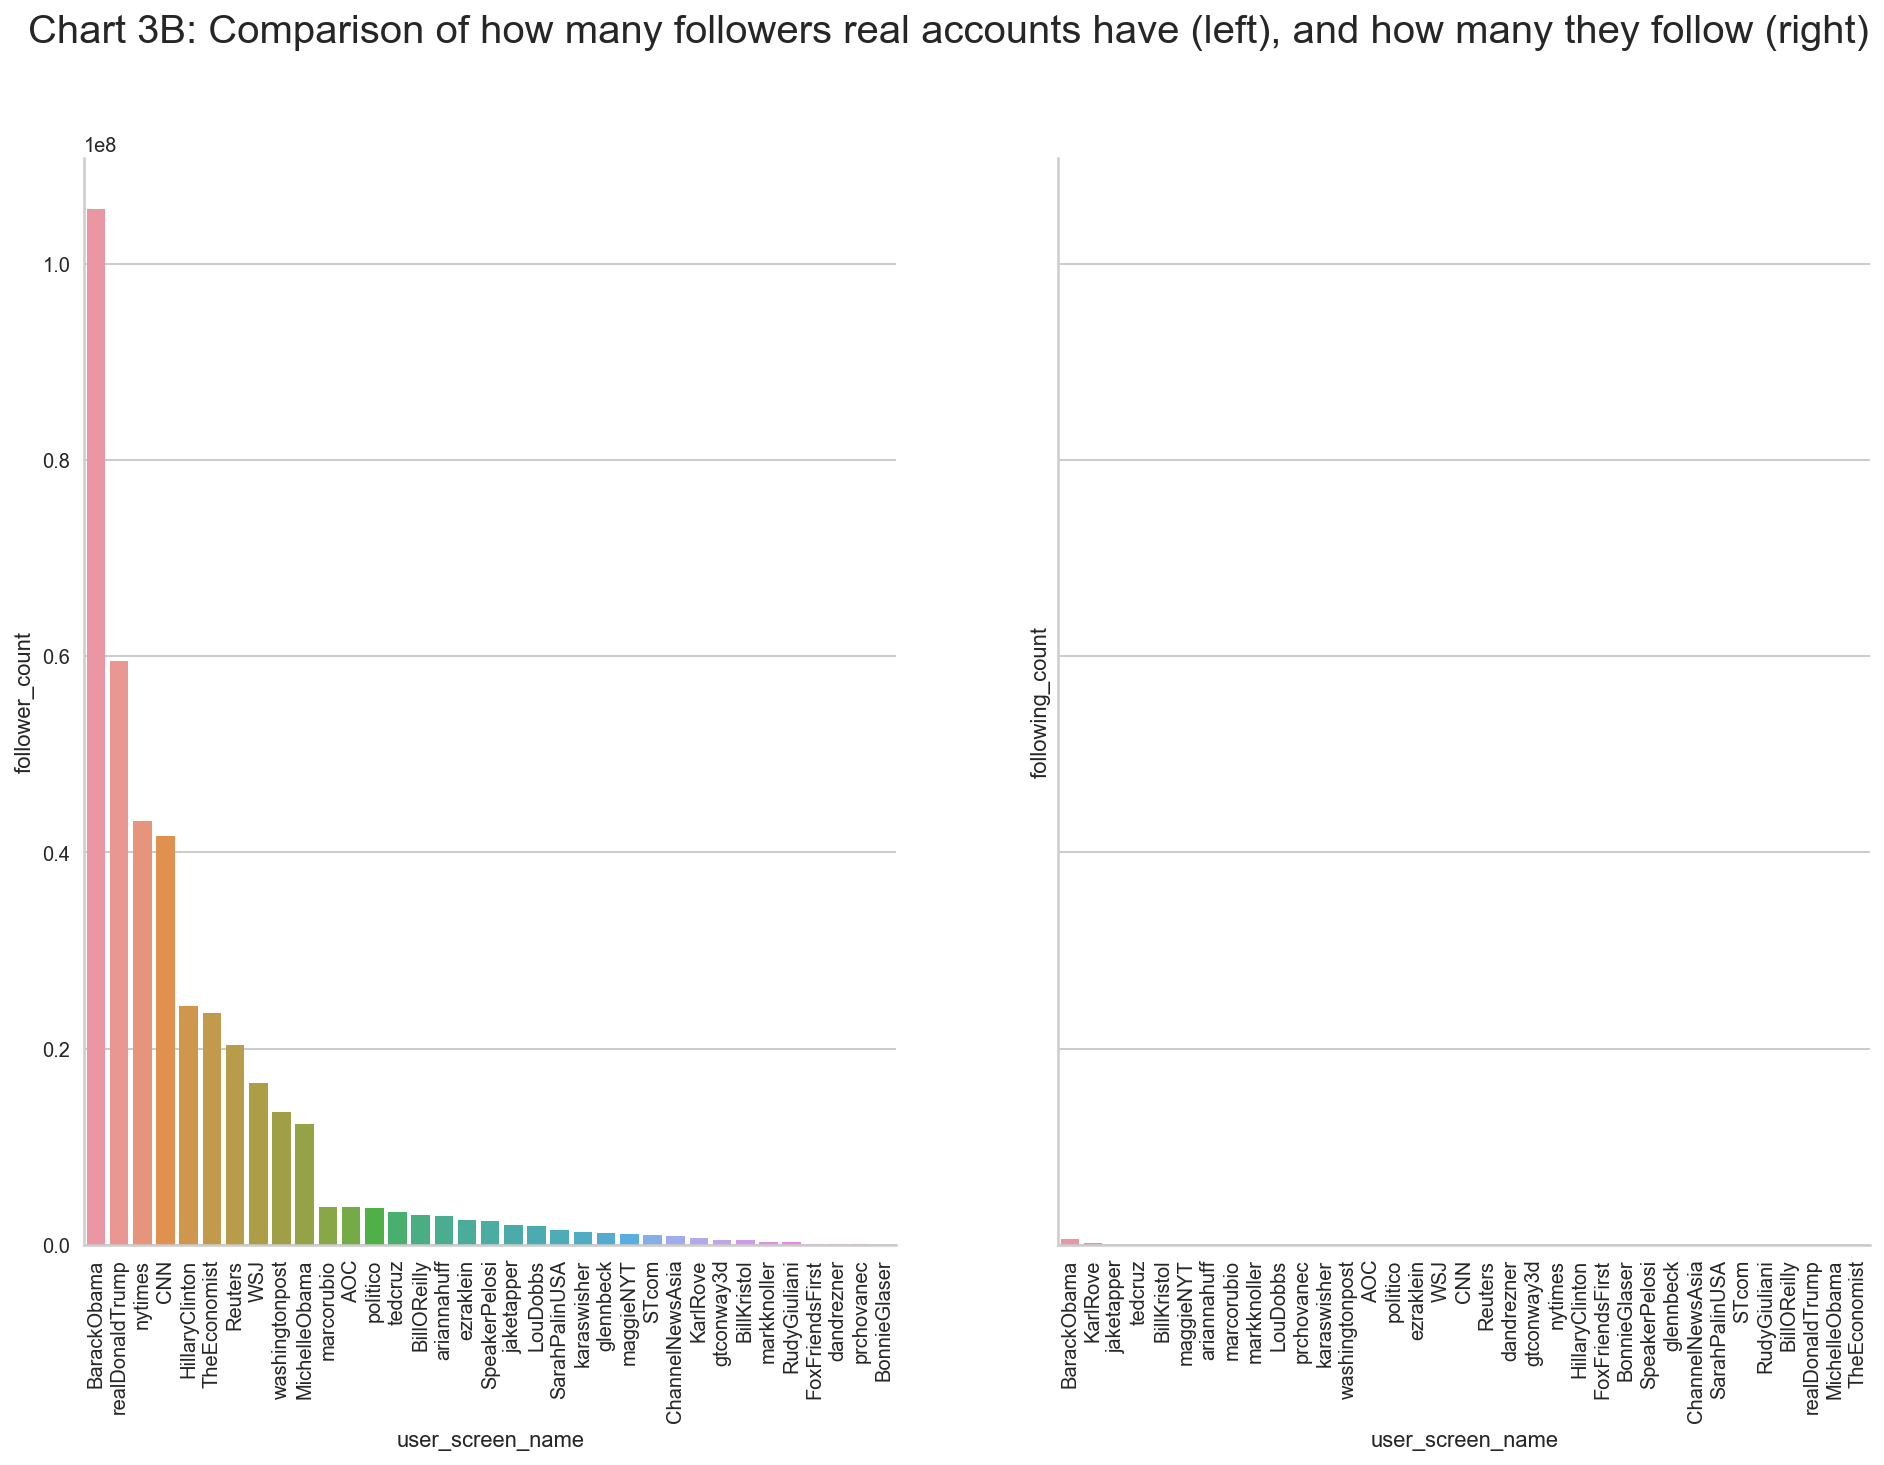

In [24]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
sns.barplot(x='user_screen_name', y='follower_count', data = follower_real, ax=axs[0])
sns.barplot(x='user_screen_name', y='following_count', data = following_real, ax=axs[1])
fig.suptitle(
    "Chart 3B: Comparison of how many followers real accounts have (left), and how many they follow (right)",
    fontsize=20,
)
for ax in axs:
    mpl.pyplot.sca(ax)
    plt.xticks(rotation=90)    
sns.despine()
plt.show()

### Let's look at a similar chart below that illustrates the number of followers Vs following for the top 10 state-backed accounts.

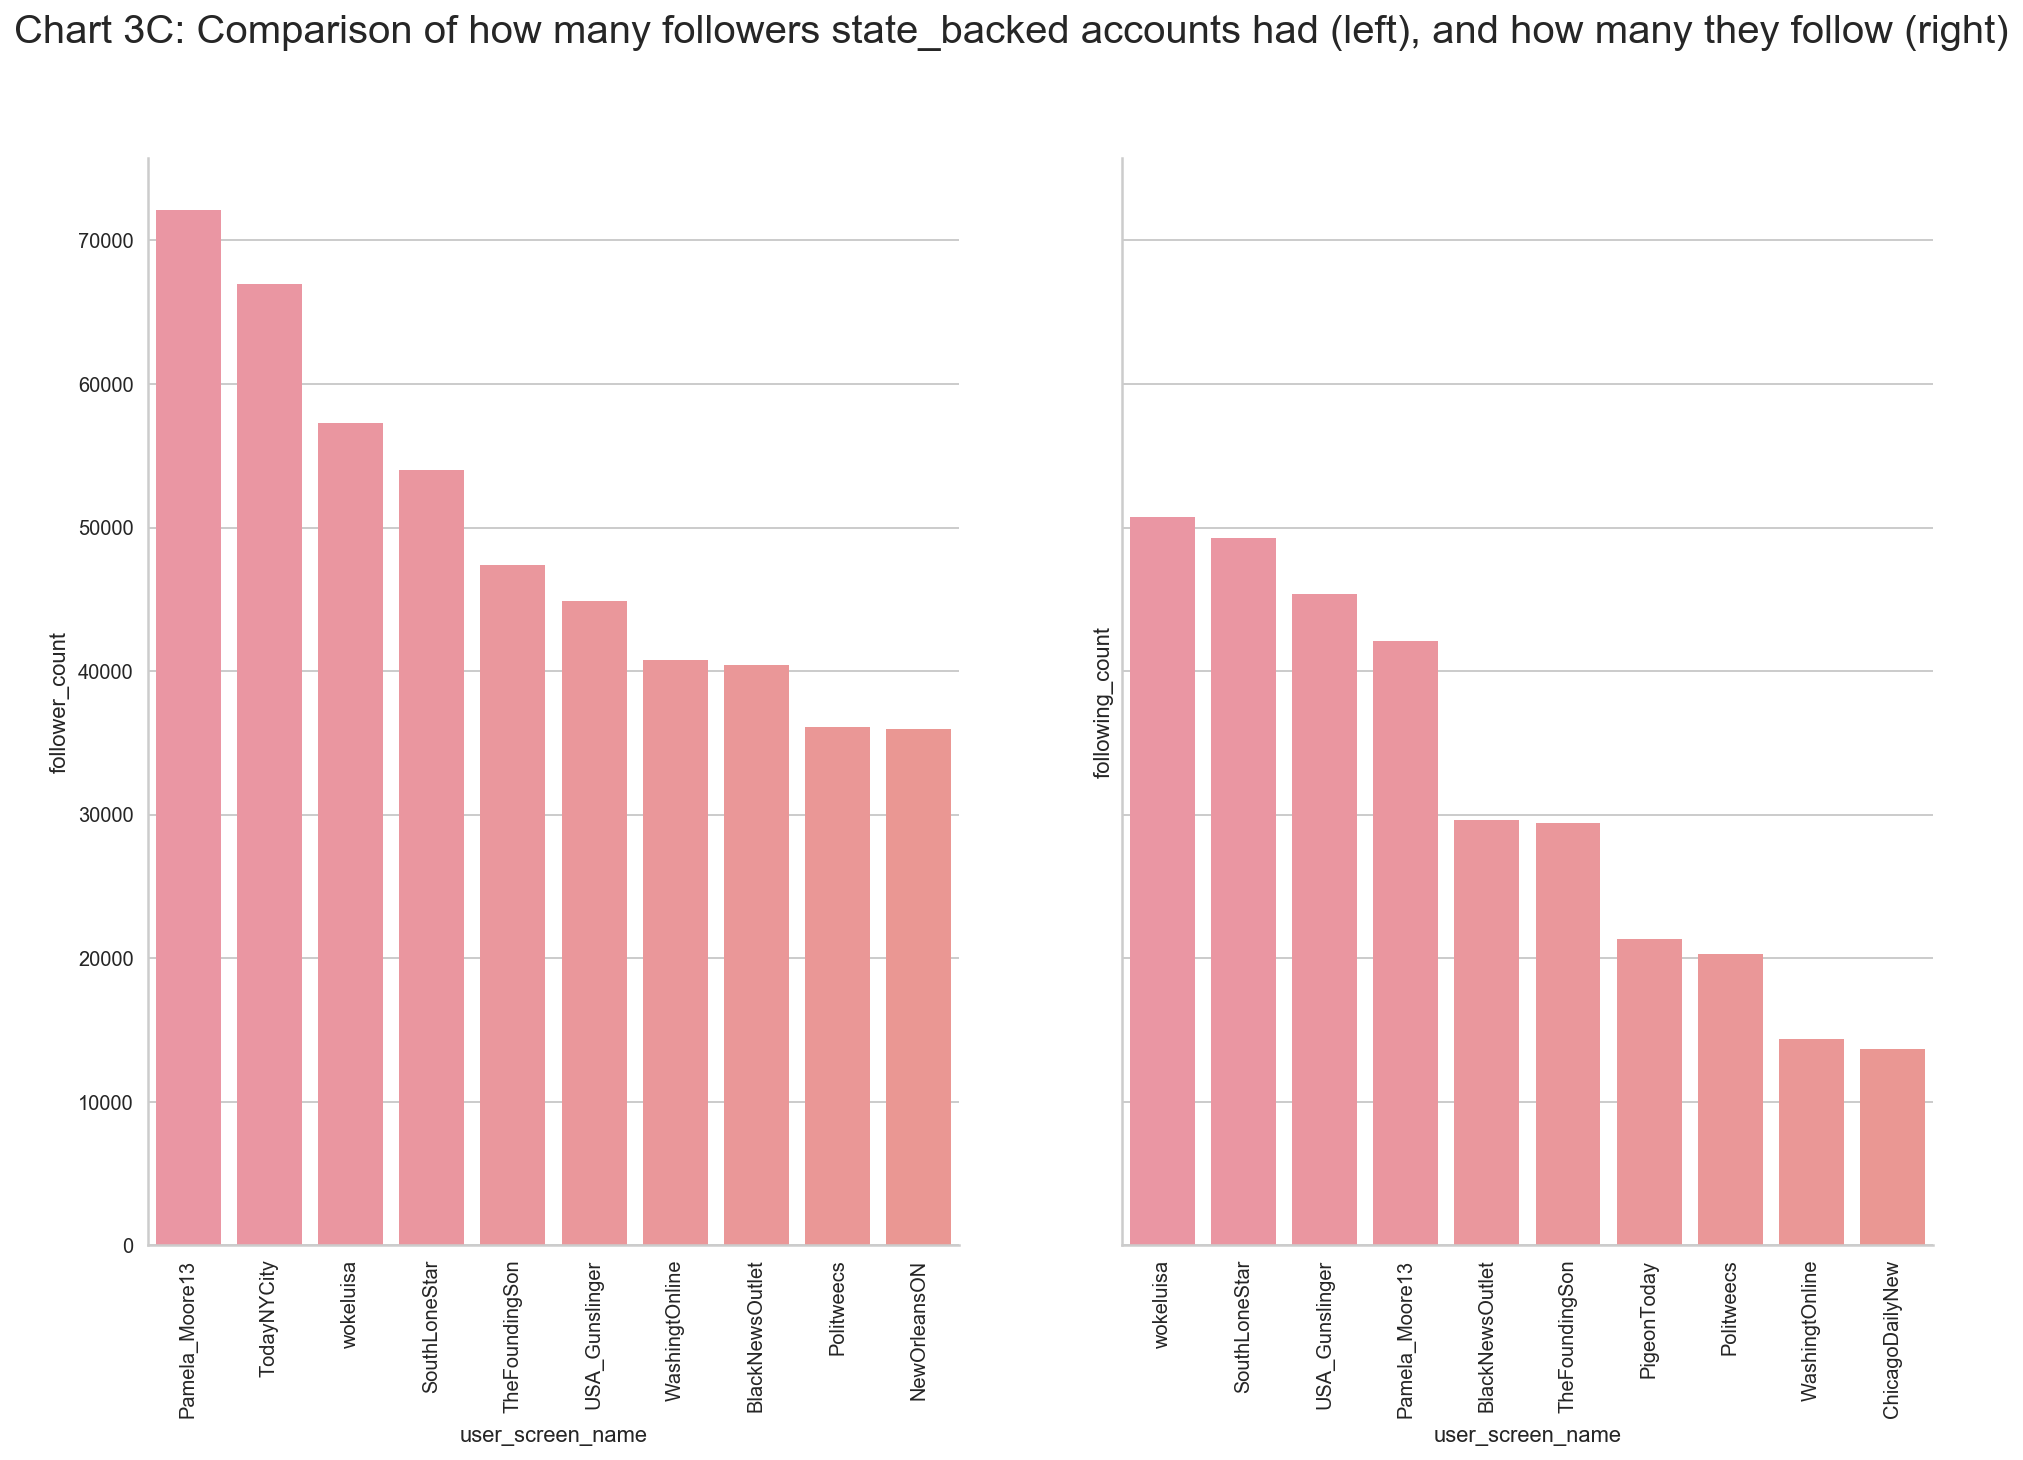

In [25]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
sns.barplot(x='user_screen_name', y='follower_count', data = follower_state, ax=axs[0])
sns.barplot(x='user_screen_name', y='following_count', data = following_state, ax=axs[1])
fig.suptitle(
    "Chart 3C: Comparison of how many followers state_backed accounts had (left), and how many they follow (right)",
    fontsize=20,
)
for ax in axs:
    mpl.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xlim(-0.5, 9.5)
    
sns.despine()
plt.show()

### At a glance, we can tell the difference right away: The top state-backed accounts all follow an extraordinarily high number of accounts, relative to the number of followers they have. The top state-backed account in our dataset, Pamela_Moore13, had over 70,000 followers. But "she" was following over 40,000 other accounts. Another state-backed account, "wokeluisa" followed over 50,000 accounts.

### This is obviously abnormal user behaviour. On Twitter, anyone following over 1,000 accounts would have a tough time managing the "fire-hose" nature of content on the platform.

### On average, state-backed accounts on average follow 8,621 users - a shockingly high number.

## 2.1 HASHTAGS

Media reports also tell us that the state-backed accounts used hashtags widely, not just the obvious ones supporting Trump and attacking Hillary, but also [non-obvious ones](https://qz.com/1207518/not-just-maga-russian-twitter-trolls-most-common-hashtags/) on divisive social issues. Let's see if this is borne out in our dataset. 

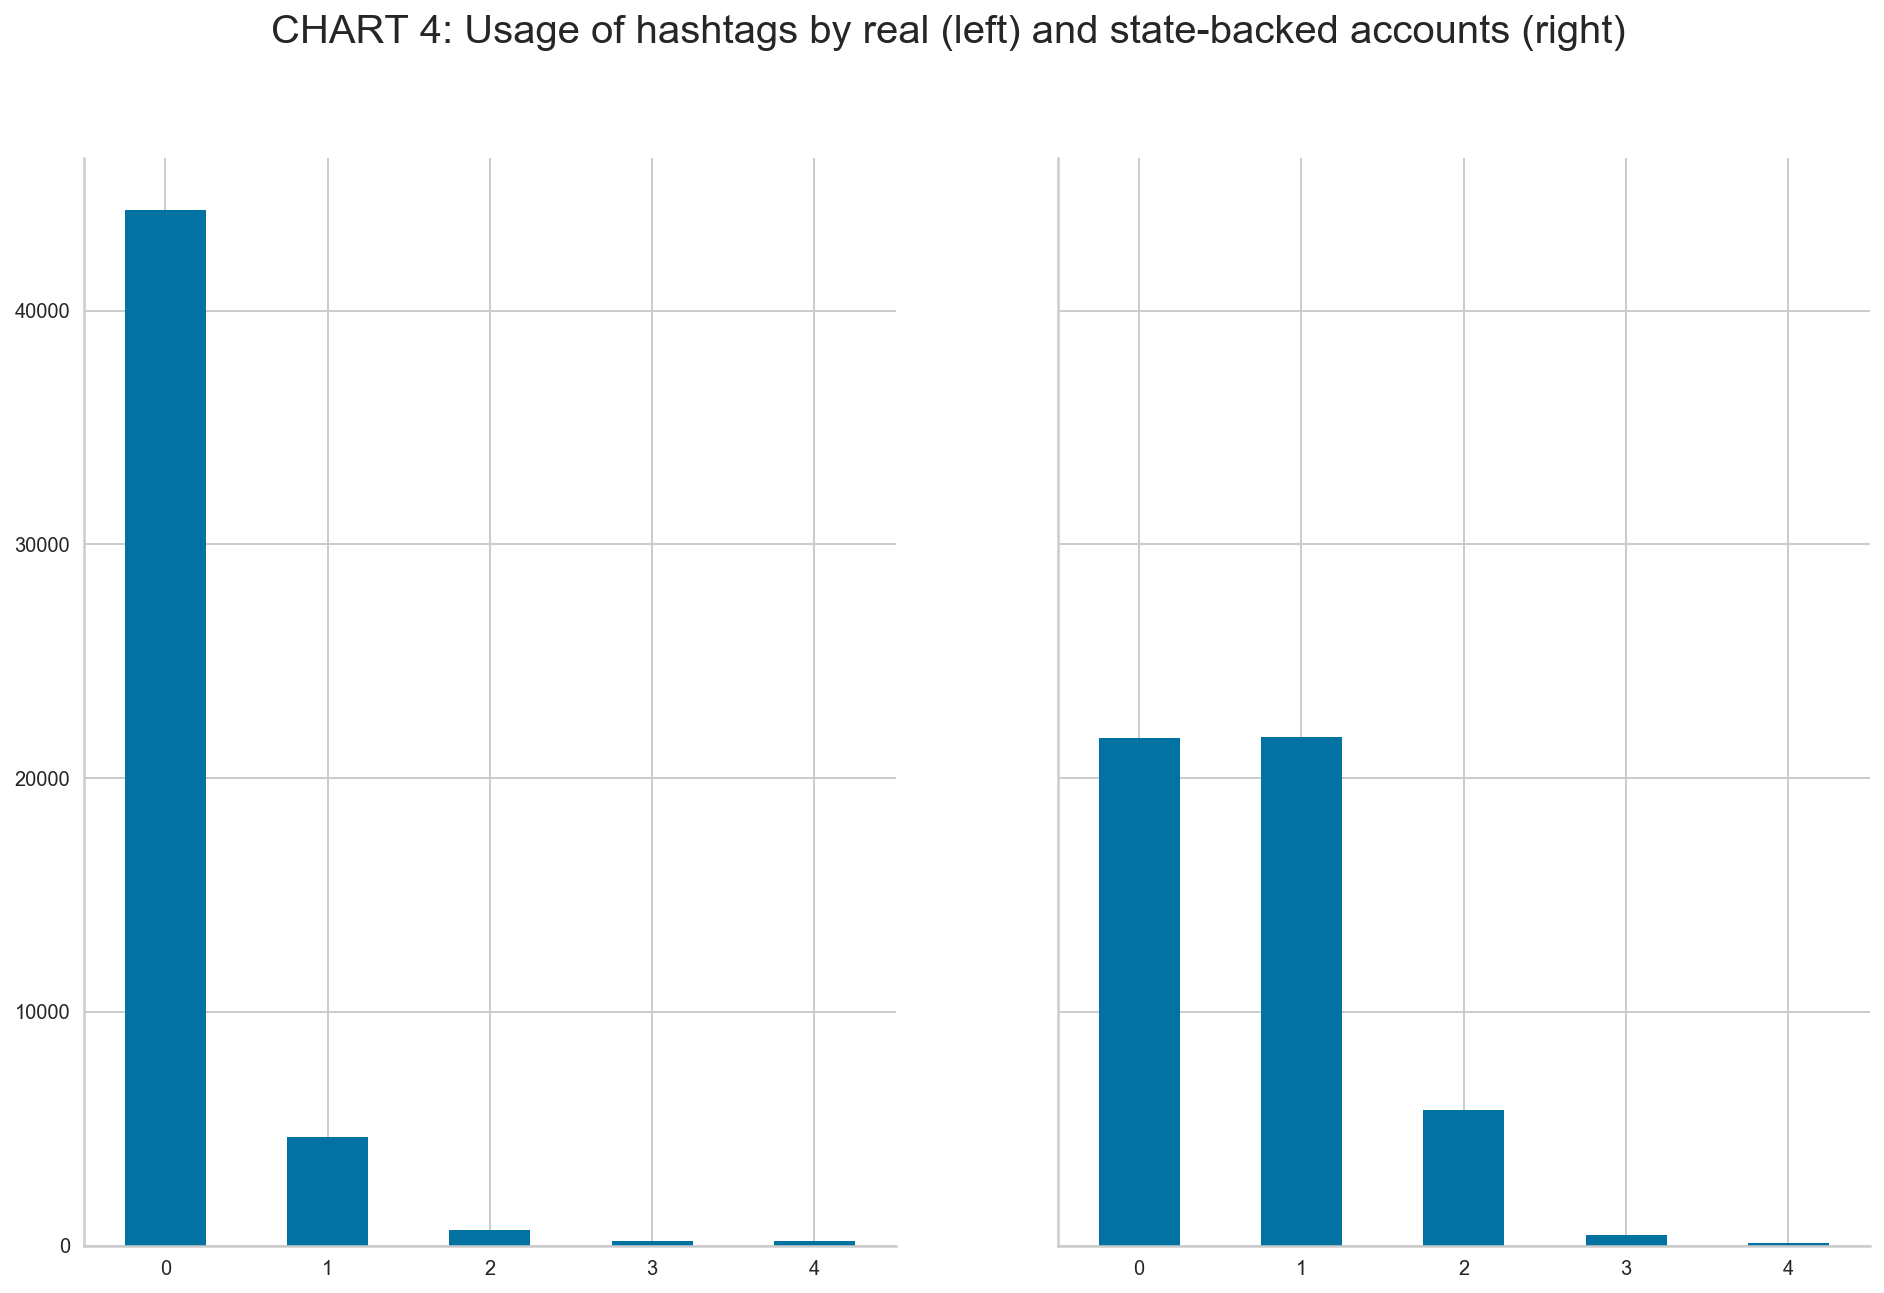

In [26]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['hashtags'].value_counts().head().plot(kind='bar', figsize=(16,10), ax=axs[0])
state['hashtags'].value_counts().sort_index(ascending=True).head().plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 4: Usage of hashtags by real (left) and state-backed accounts (right)",
    fontsize=20,
)
for ax in axs:
    mpl.pyplot.sca(ax)
    plt.xticks(rotation=0)
    plt.xlim([-0.5, 4.5])
sns.despine()
plt.show()

In [27]:
state['hashtags'].value_counts().head()

1    21746
0    21726
2     5786
3      452
4      127
Name: hashtags, dtype: int64

As expected, we see state-backed accounts using visibly more hashtags than real users, whose tweets mostly don't contain hashtags.

## 2.2 LINKS (URLs)
URLs are highly used in tweets. Are there differences in how real and state_backed accounts use them?

In [28]:
real['links'].value_counts().sort_index(ascending=True)

0     6786
1    37959
2     5245
3        9
4        1
Name: links, dtype: int64

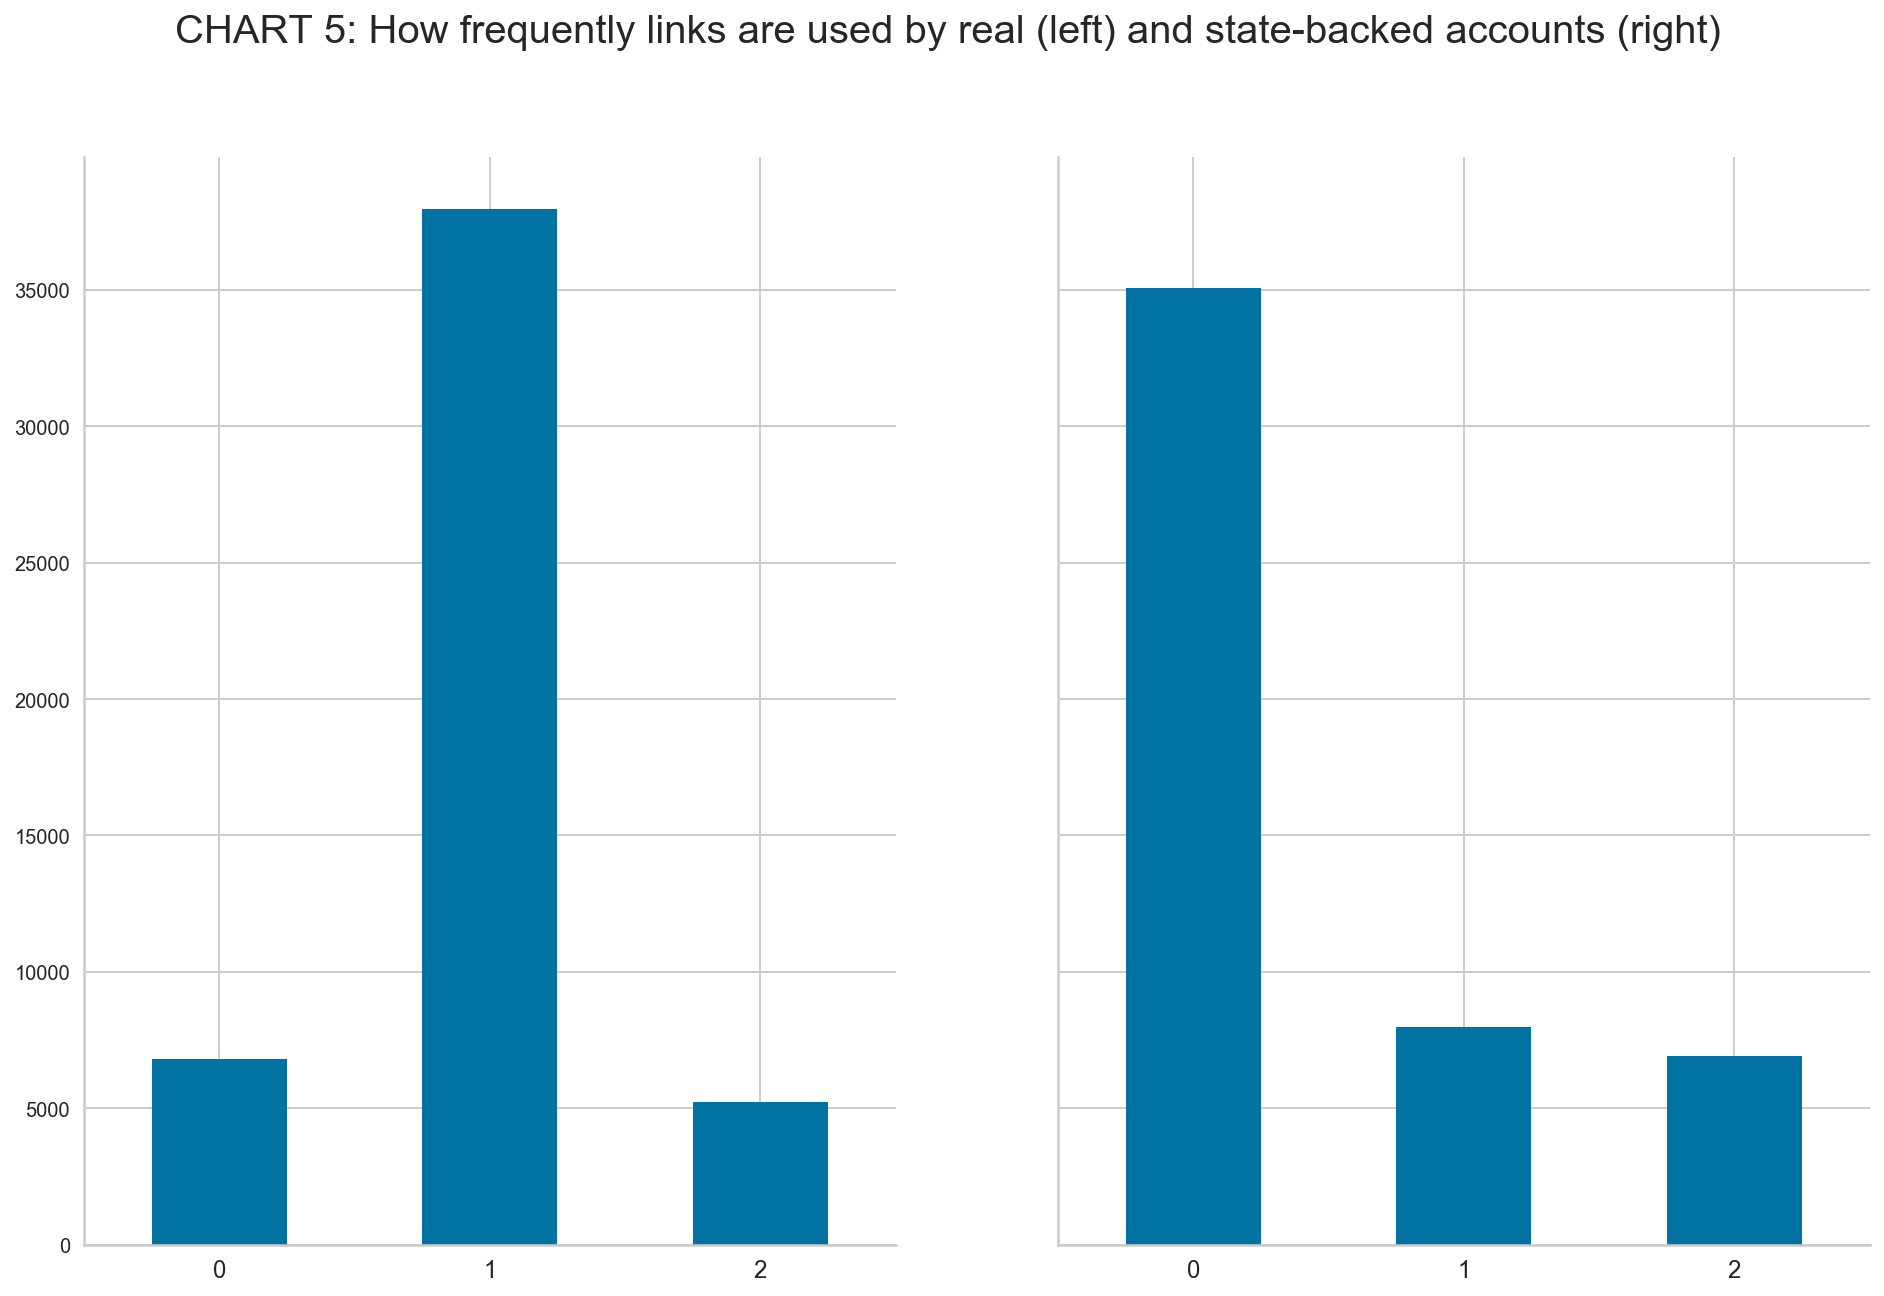

In [29]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['links'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(16,10), ax=axs[0])
state['links'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 5: How frequently links are used by real (left) and state-backed accounts (right)",
    fontsize=20,
)
labels = range(0,3)
for ax in axs:
    mpl.pyplot.sca(ax)
    plt.xticks(rotation=0)
    plt.xlim([-0.5, 2.5])
    ax.set_xticklabels(labels, fontsize=12, rotation=0)
sns.despine()
plt.show()

### Interestingly, real users used links/URLs more frequently than state-backed accounts. But this could be due to the fact that state-backed accounts chose to use RTs and hashtags more often.

## 2.3 USE OF UPPER CASE WORDS IN TWEETS
Uppercase words in tweets are often used to convey anger and intense emotions, or to emphasize a point. Is there a difference in how both real and state-backed users used this feature?

In [30]:
real['upper'].value_counts().head()

0    33035
1    12222
2     3389
3      900
4      289
Name: upper, dtype: int64

In [31]:
state['upper'].value_counts().head()

0    35923
1    11011
2     2152
3      468
4      130
Name: upper, dtype: int64

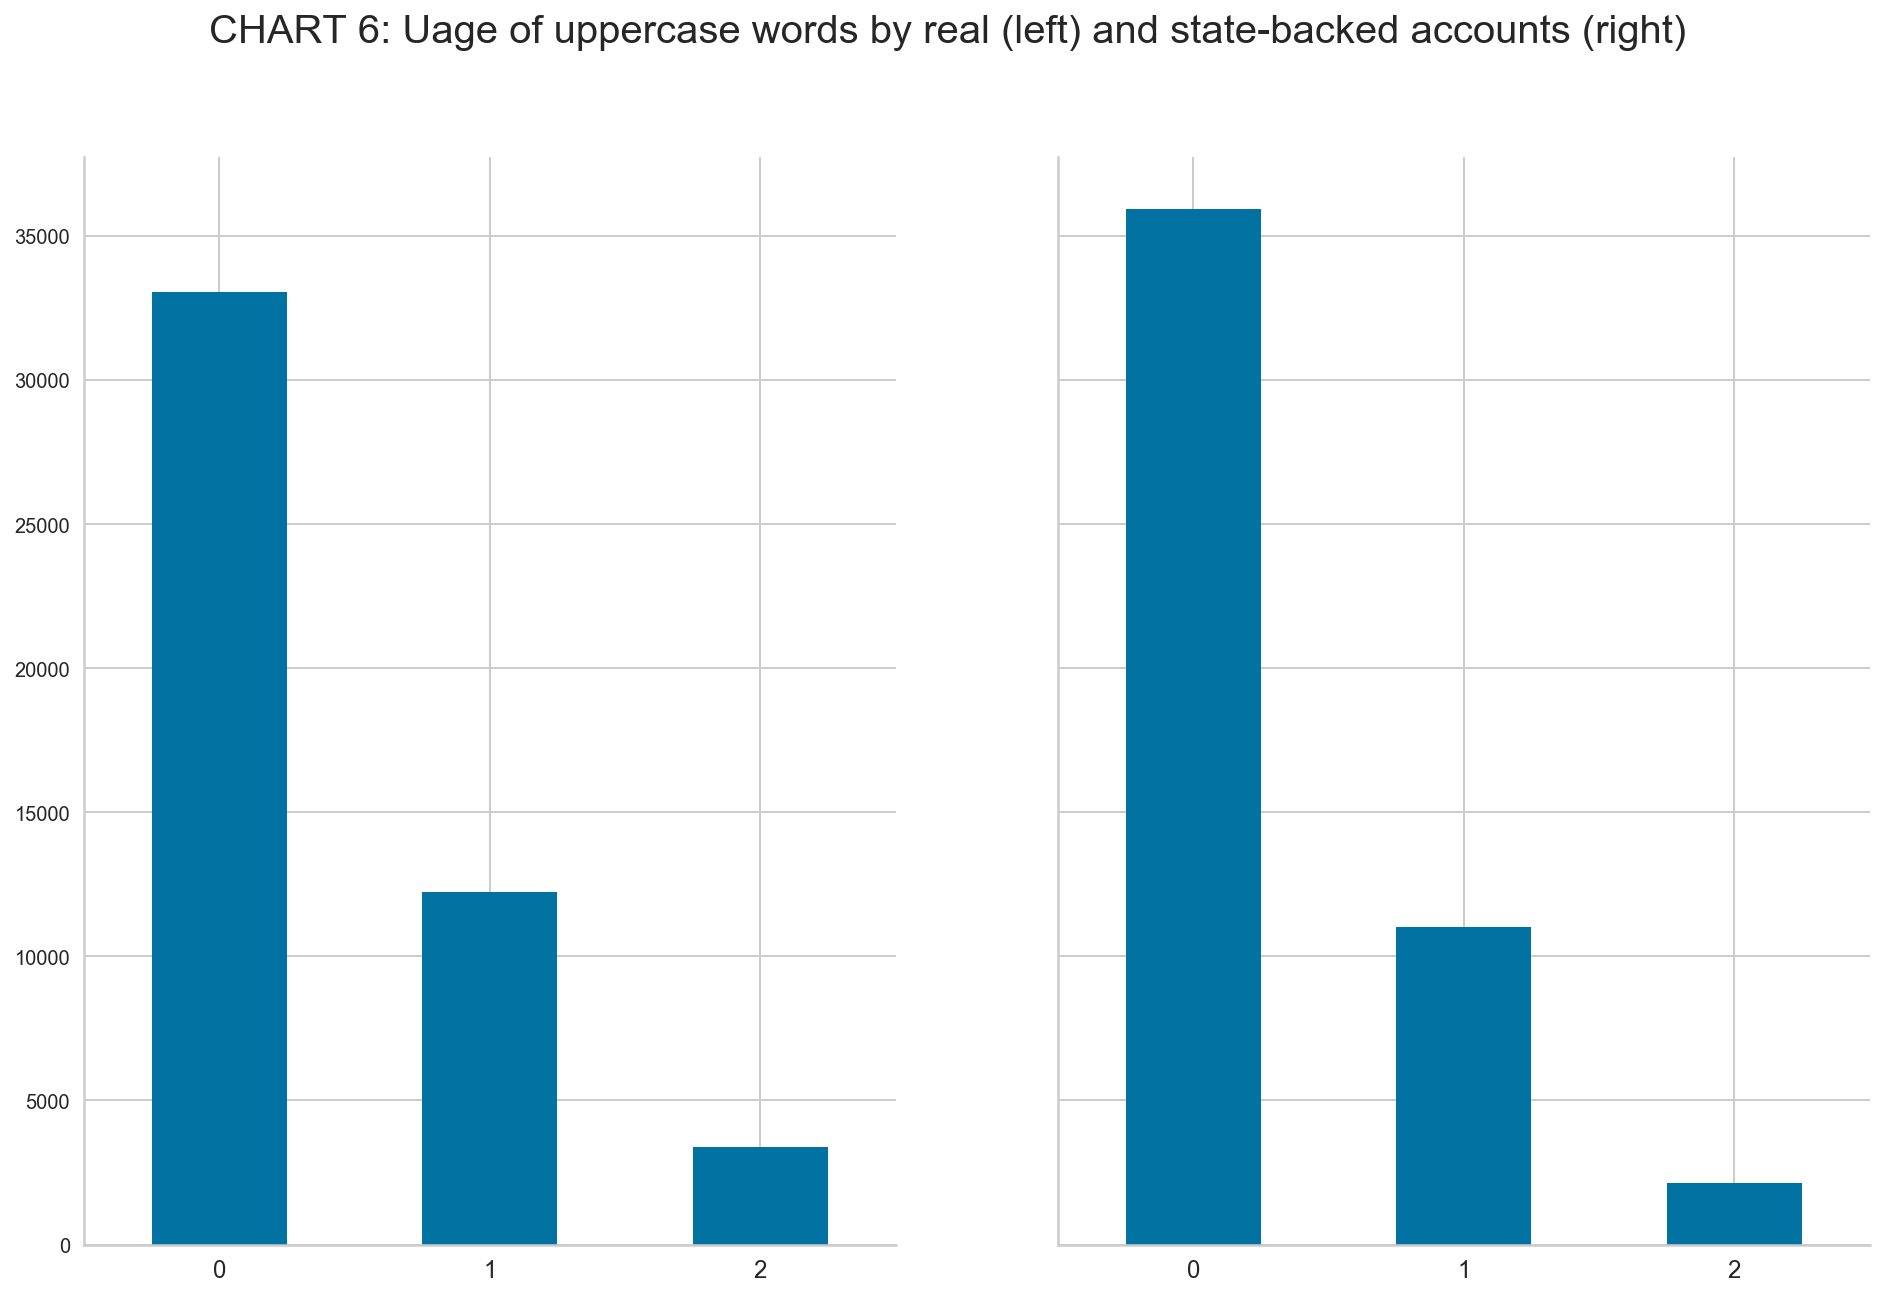

In [32]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['upper'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(16,10), ax=axs[0])
state['upper'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 6: Uage of uppercase words by real (left) and state-backed accounts (right)",
    fontsize=20,
)
labels = range(0,3)
for ax in axs:
    mpl.pyplot.sca(ax)
    plt.xticks(rotation=0)
    plt.xlim([-0.5, 2.5])
    ax.set_xticklabels(labels, fontsize=12, rotation=0)
sns.despine()
plt.show()

### Upper case letters are used less frequently than thought by both camps. And surprisingly, real accounts used slightly more uppercase letters than state-backed ones in our dataset.

## 2.4 CHARACTER COUNT
It has been observed that tweets from state-backed accounts are shorter, likely due to the large number of tweets they are sending or automating. Let's see if this is true.


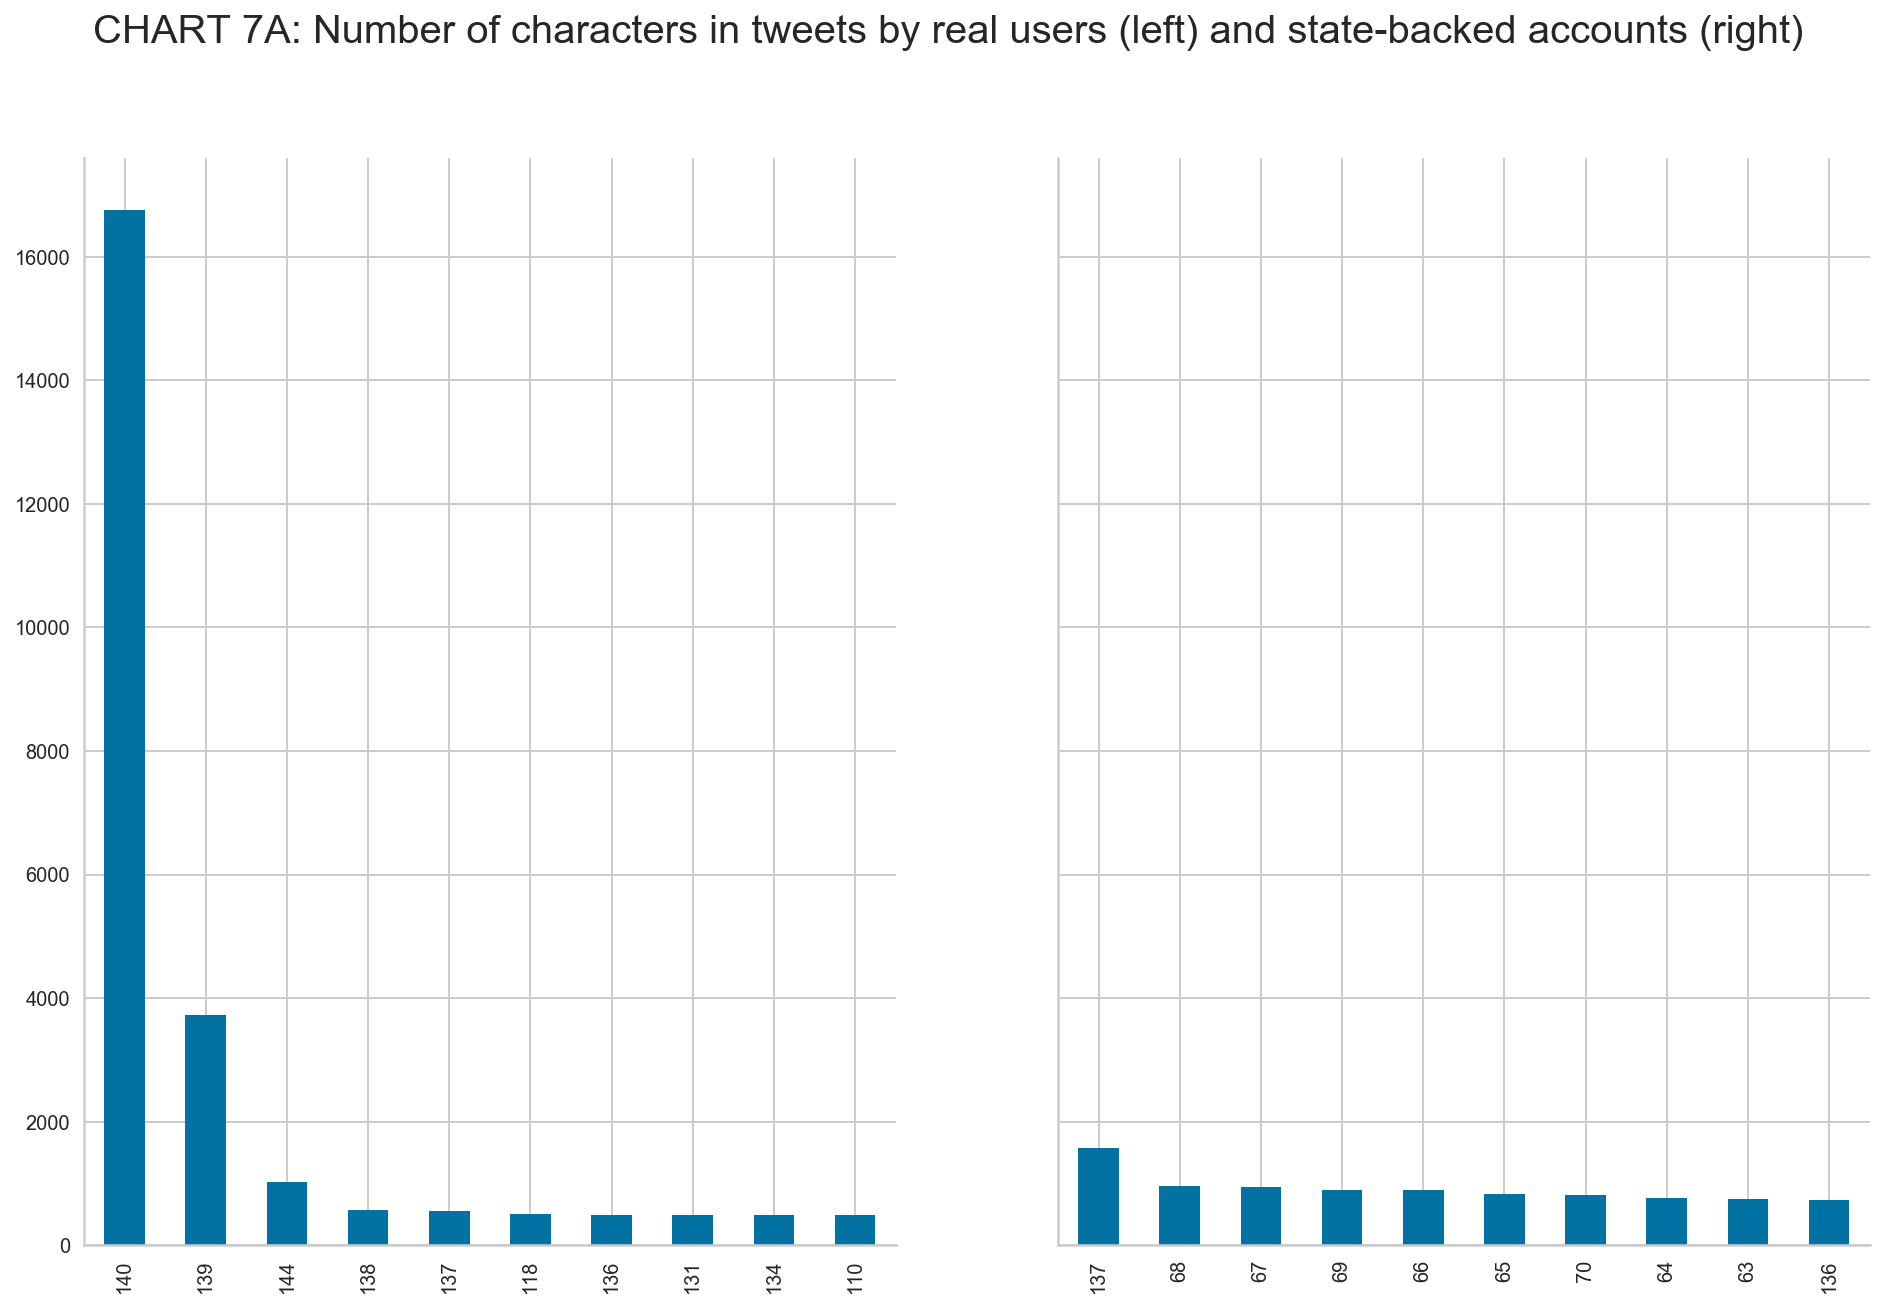

In [33]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['char_count'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(16,10), ax=axs[0])
state['char_count'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 7A: Number of characters in tweets by real users (left) and state-backed accounts (right)",
    fontsize=20,
)
sns.despine()
plt.show()

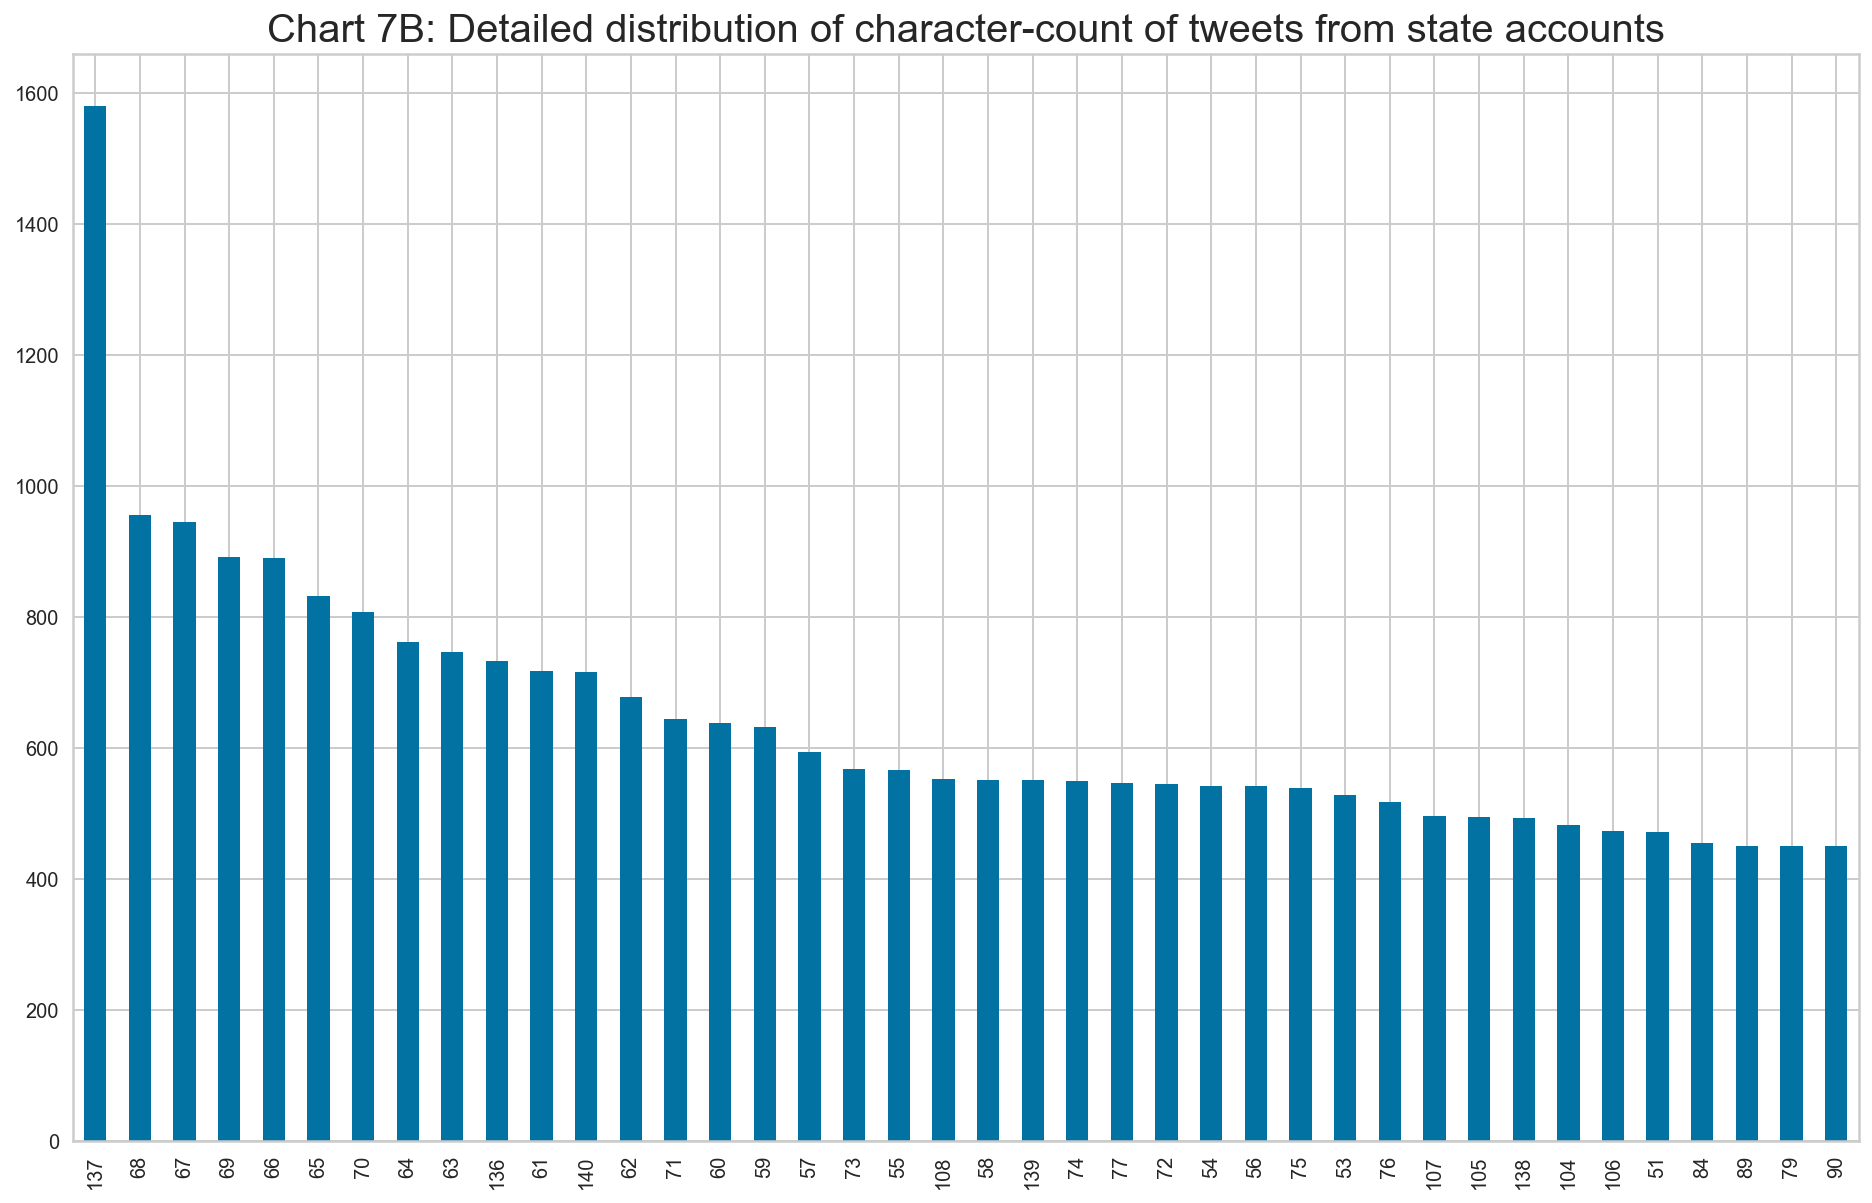

In [34]:
plt.figure(figsize=(16,10))
state['char_count'].value_counts().sort_values(ascending=False).head(40).plot.bar()
plt.title('Chart 7B: Detailed distribution of character-count of tweets from state accounts', fontsize=20)
plt.show()

### Chart 7A clearly shows how real tweets are mostly longer, and fully written. In comparison, the right-corner chart on 7B and the detailed distribution shown in Chart 7B show that tweets by state-backed accounts are mostly shorter.

## 2.5 WORD COUNT
This is similar to character-count, but could offer us another layer of insight into the differences between real and state-tweets.

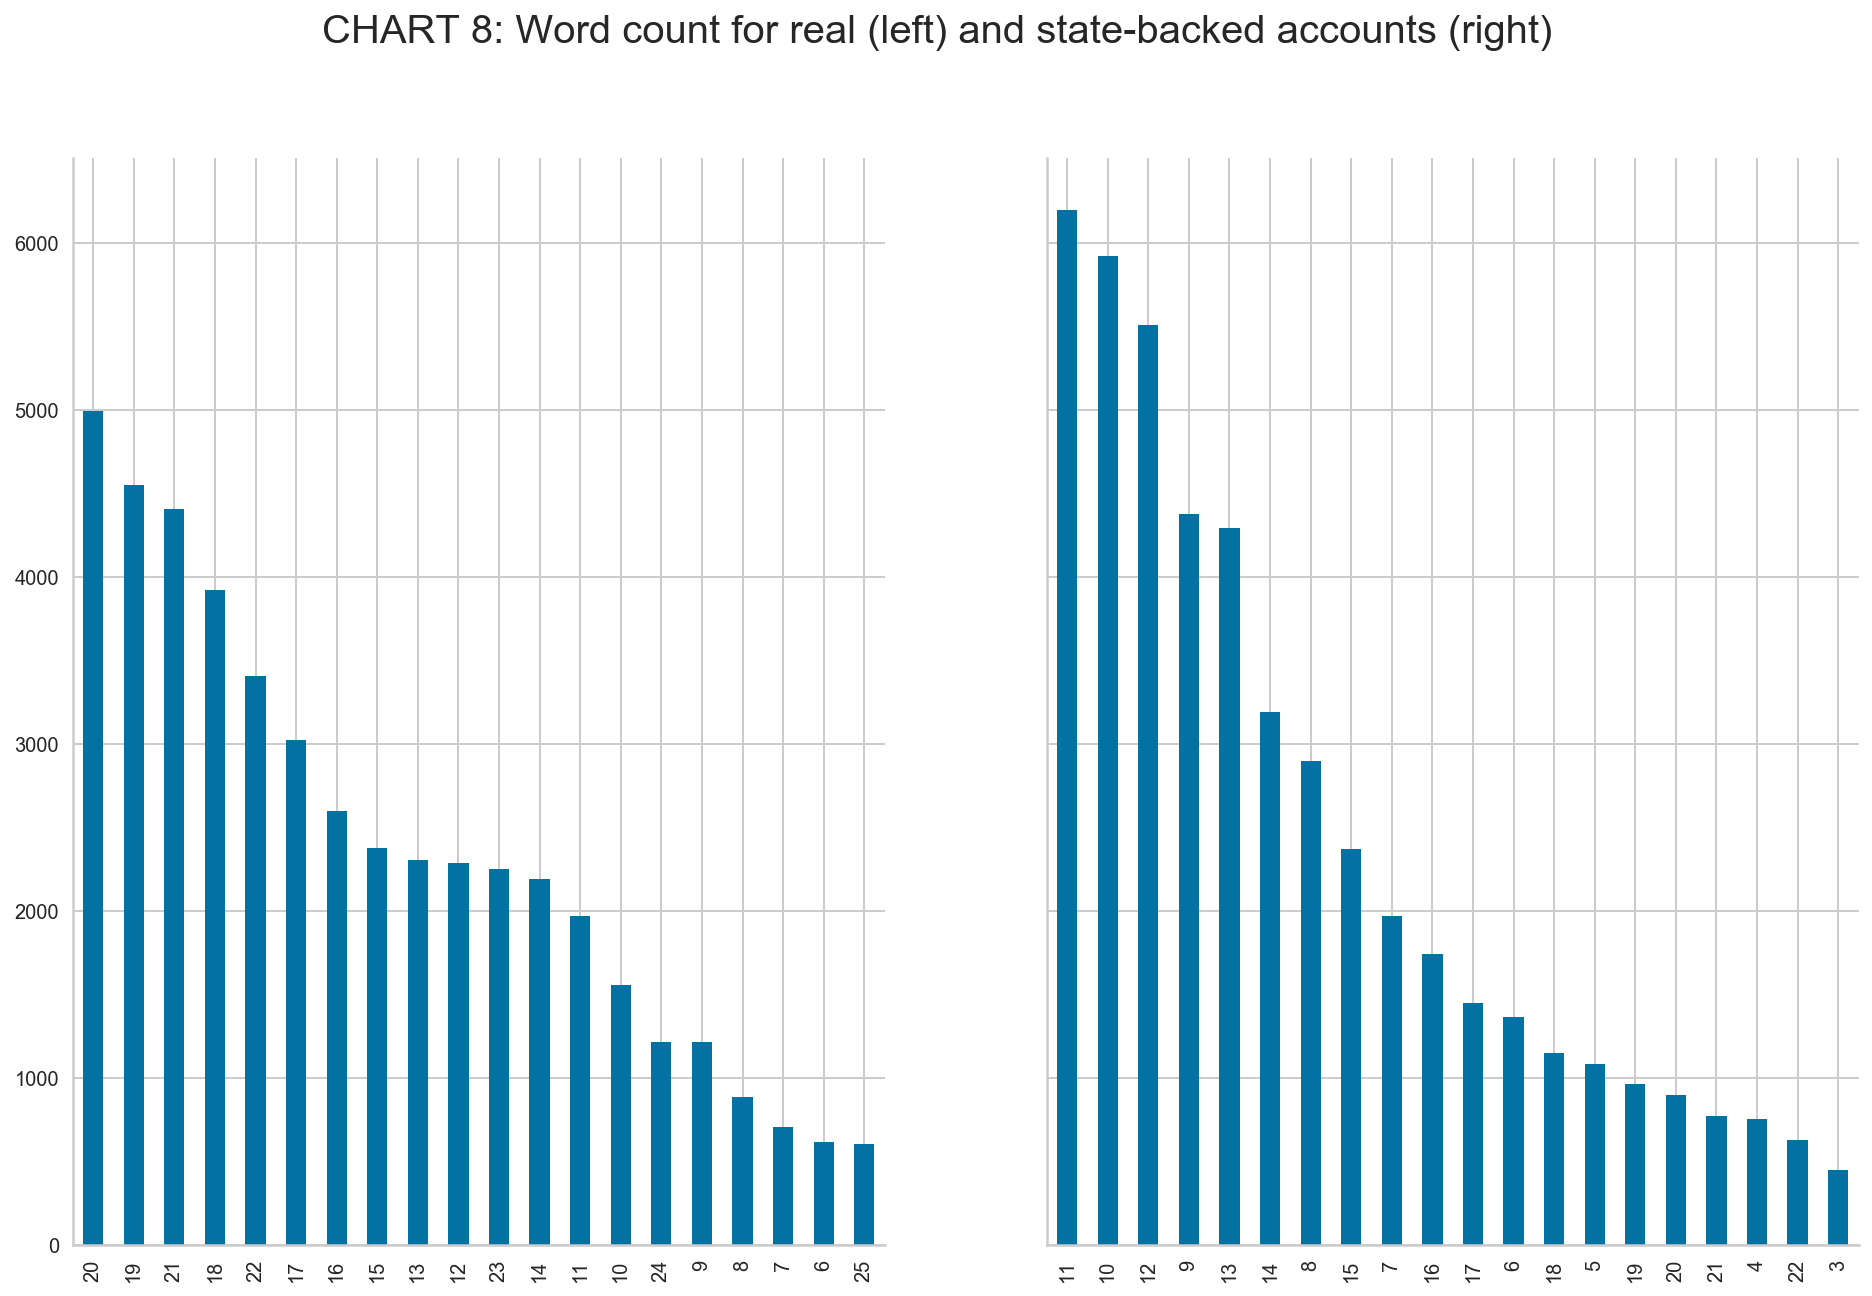

In [35]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['tweet_word_count'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(16,10), ax=axs[0])
state['tweet_word_count'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 8: Word count for real (left) and state-backed accounts (right)",
    fontsize=20,
)

sns.despine()
plt.show()

### This is consistent with the earlier chart on character-count, showing that real tweets are longer and contain more words. The bulk of state-backed tweets have 11-14 words or less. 

## 2.6 LOCATIONS
This refers to the self-reported locations of where the users are from. Naturally the state-backed accounts won't say they are from Russia. Let's see where they claim to be from. 

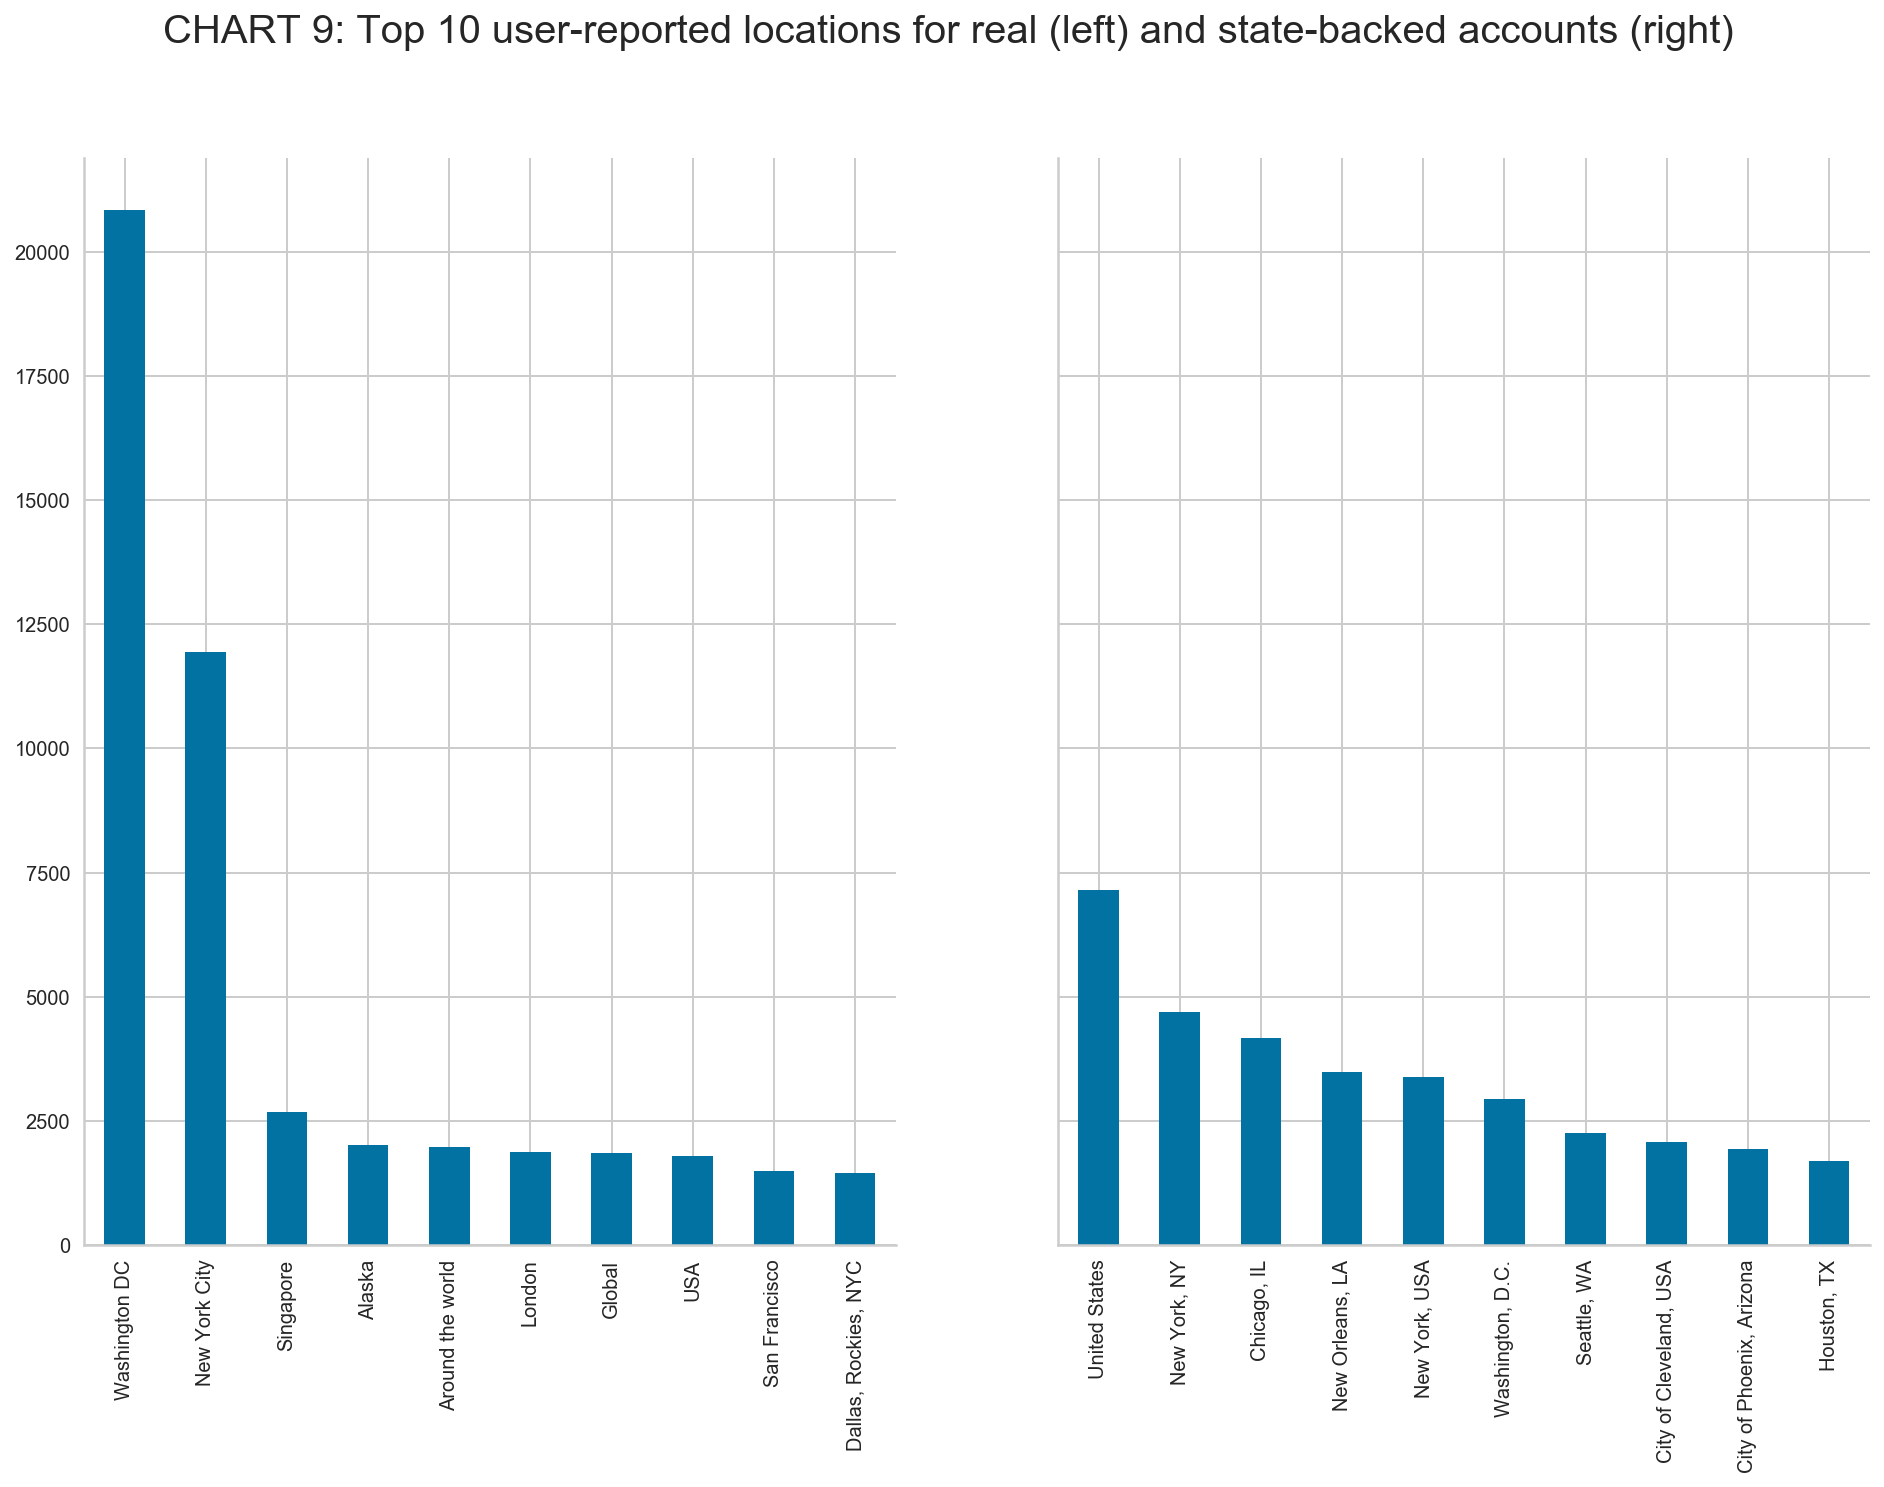

In [36]:
fig, axs = plt.subplots(1,2, figsize=(16,10), sharey=True)
real['user_reported_location'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(16,10), ax=axs[0])
state['user_reported_location'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(16,10), ax=axs[1])
fig.suptitle(
    "CHART 9: Top 10 user-reported locations for real (left) and state-backed accounts (right)",
    fontsize=20,
)

sns.despine()
plt.show()

### It is striking that the top state-backed accounts all claimed to be tweeting from the US.

## 3. CONTENT CHARACTERISTICS OF REAL VS STATE-BACKED TWEETS/ACCOUNTS
Now let's look at the content of the tweets by both camps and see if we can discern any noticeable differences and trends which might add to the building of a "digital fingerprint" of a state troll.

## 3.1 MOST FREQUENTLY USED TERMS IN TWEETS

In [37]:
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(state['clean_tweet_text'].dropna())
features = vect.get_feature_names()

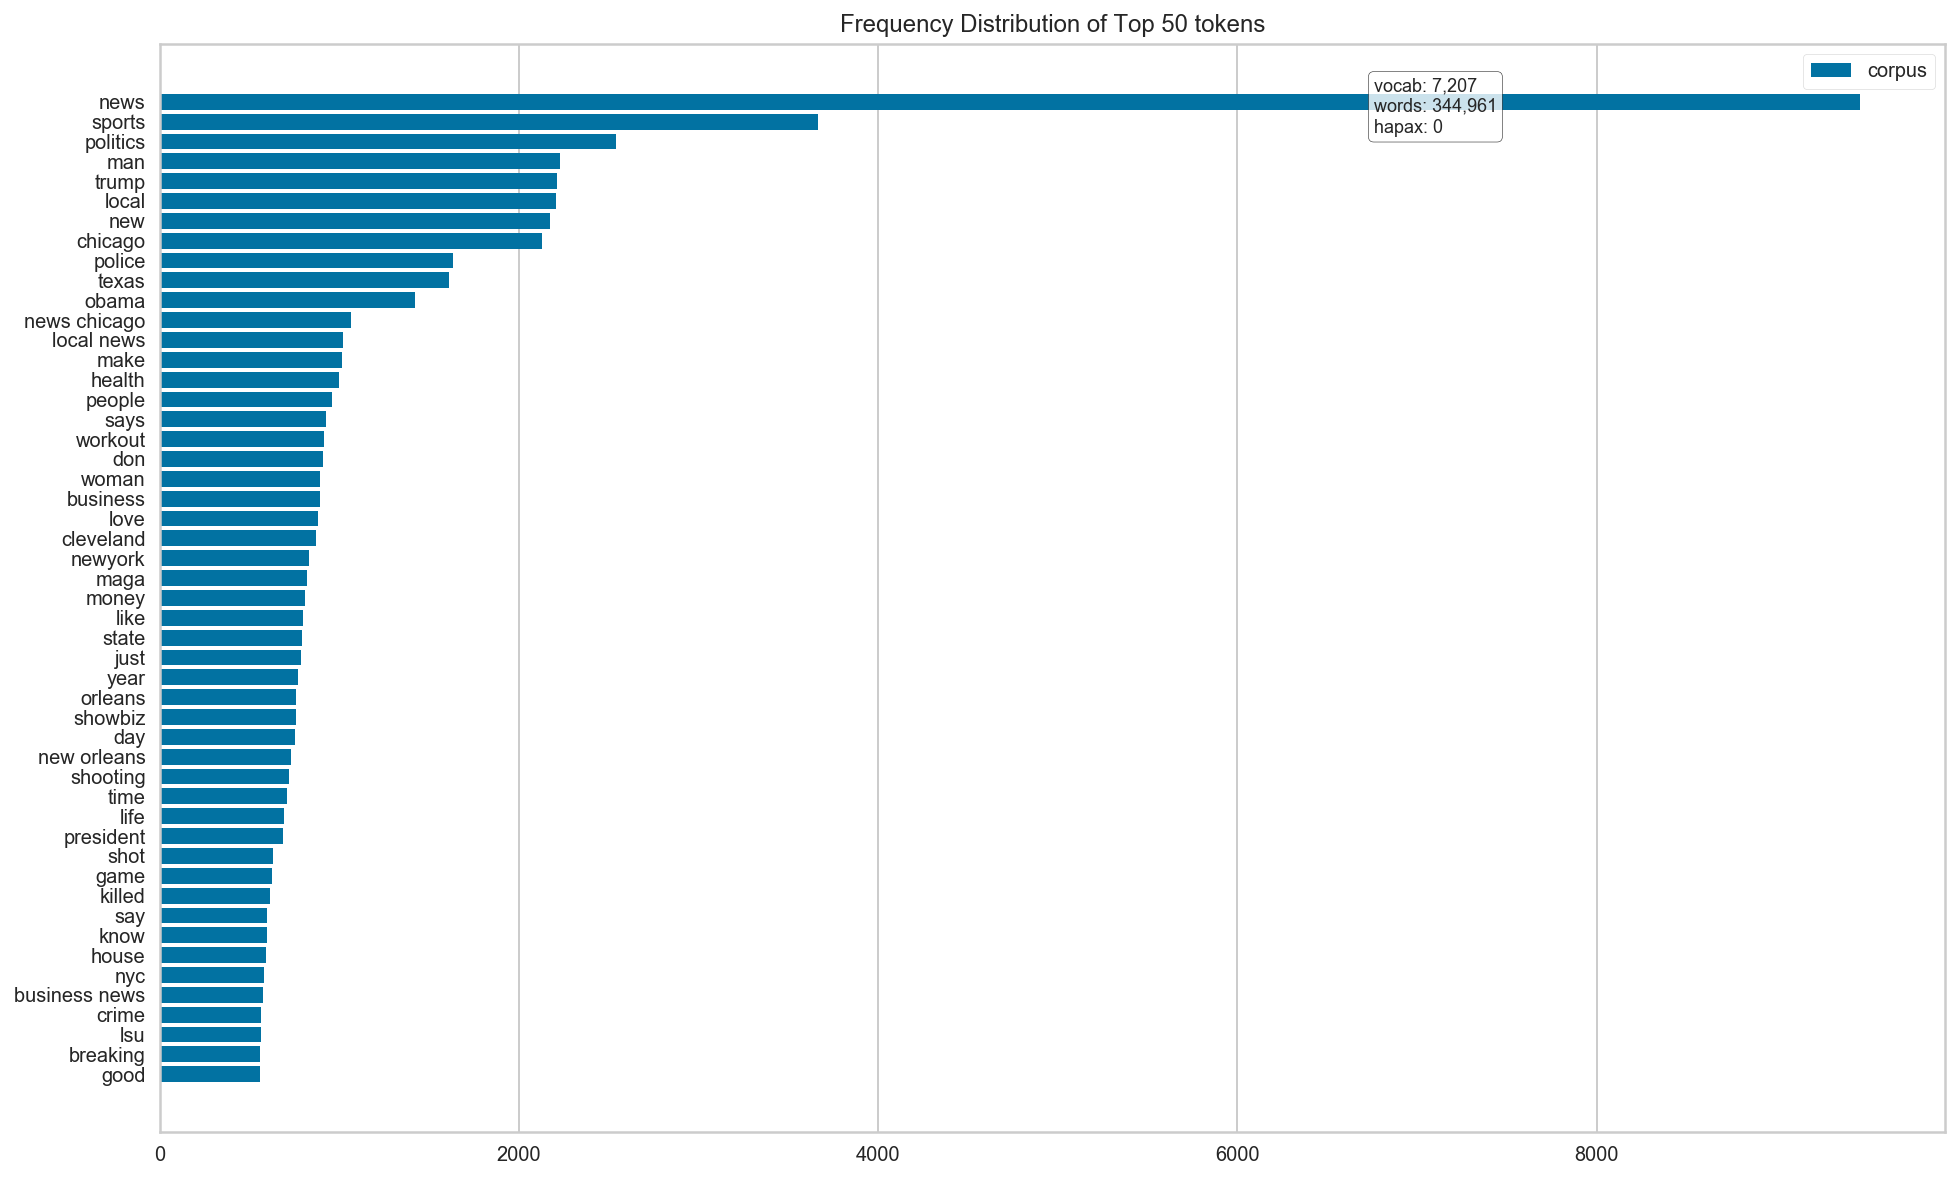

In [38]:
plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

### Chart 10A (ABOVE): Top 50 words used in tweets by state-backed accounts.

### Chart 10B (BELOW): Top 50 words used in tweets by real accounts.

In [39]:
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(real['clean_tweet_text'].dropna())
features = vect.get_feature_names()

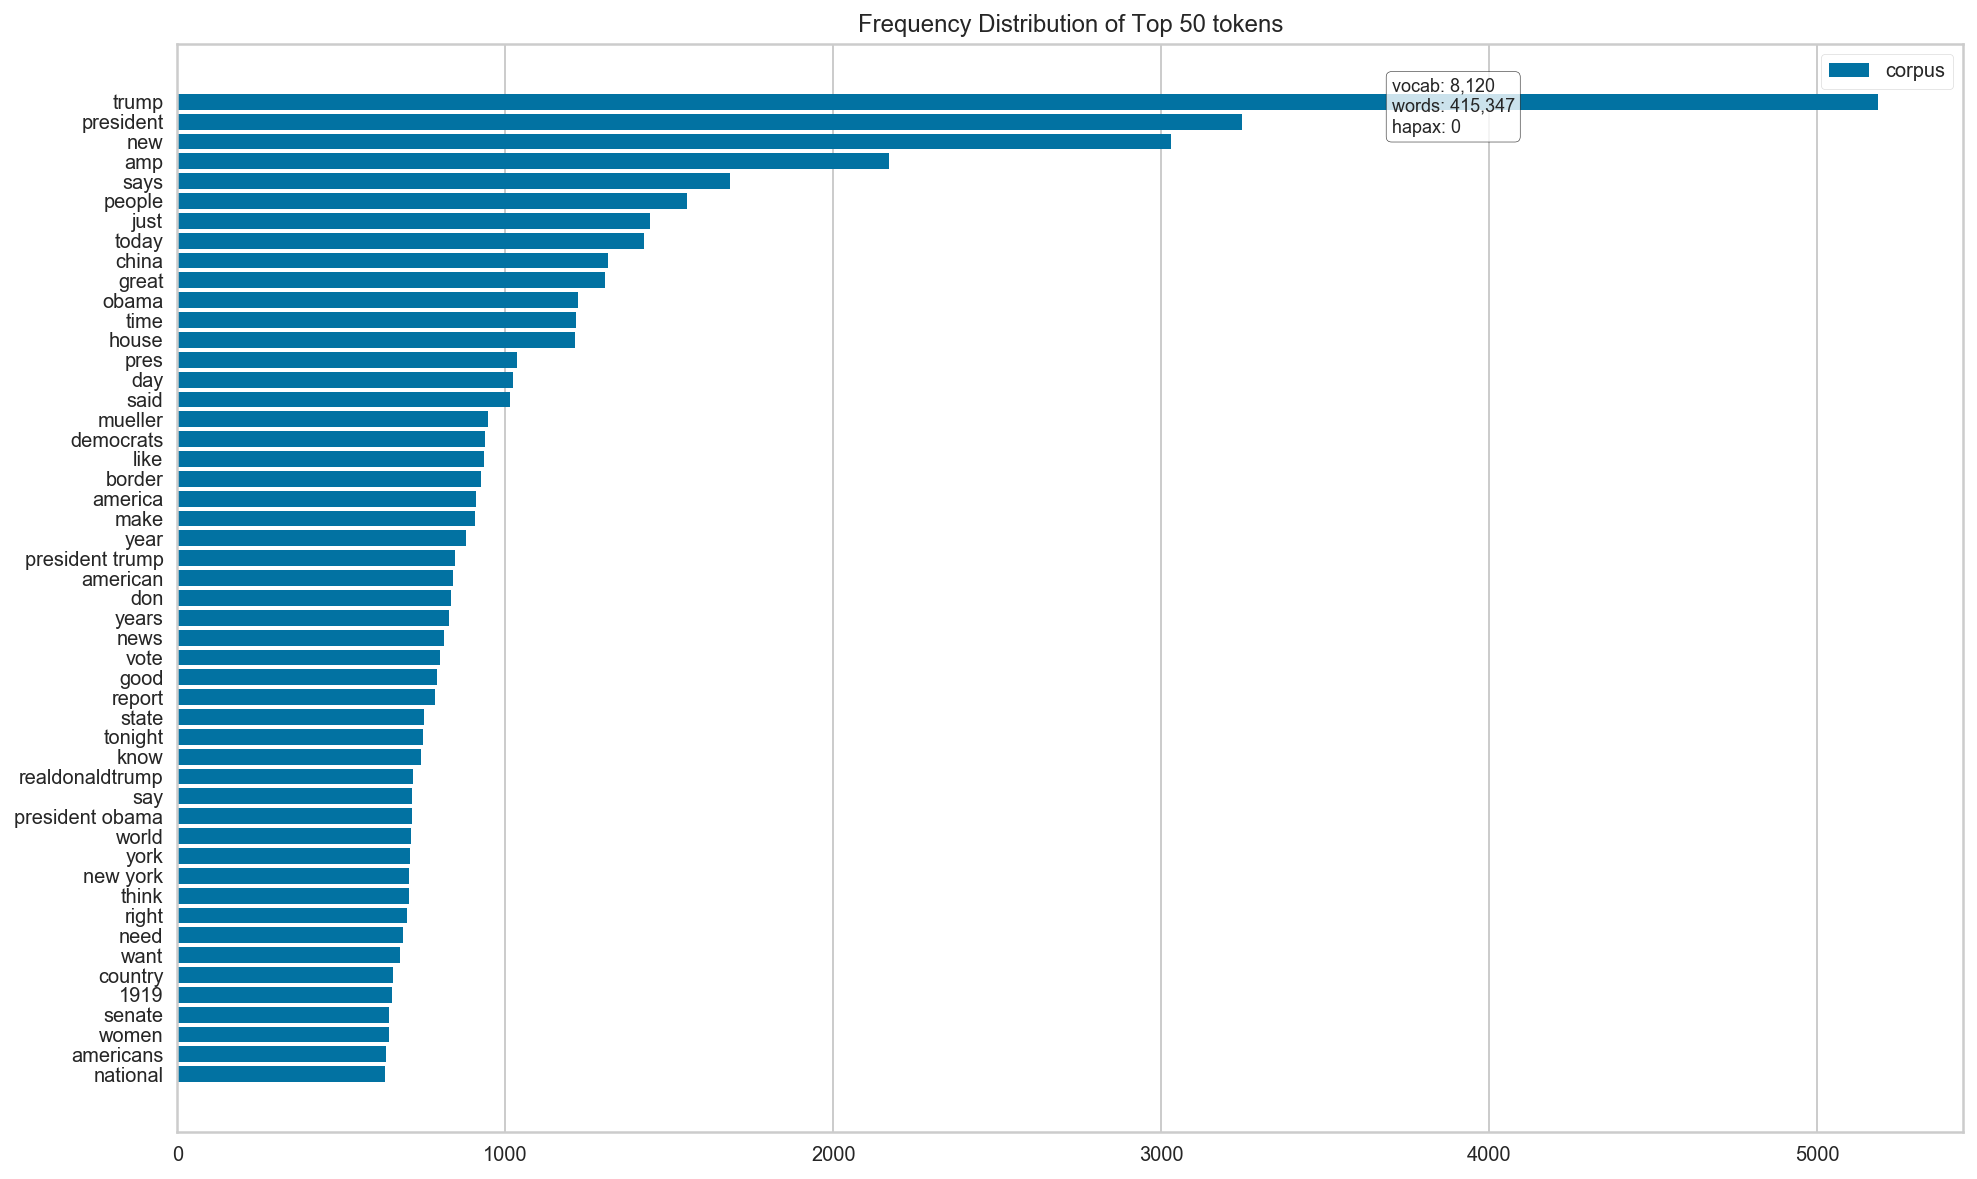

In [40]:
plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

### ANALYSIS:
It seems strange at first that the top terms in the state-backed tweets would be "news", "sports", and "politics". "Trump" is only the 5th most frequently used term, followed by others that hint at local news events.

But on hindsight, this makes perfect sense as this is how state-backed accounts disguise their activities on Twitter - by trying to pass themselves off as online news outlets, or by spreading what seems like news (but could in fact be disinformation). 

The state-backed operators are sophisticated users who know better than to be too obvious with efforts to support Trump and disparage Hillary Clinton. As such, you see innocuous terms like "health" and "workout" mixed in frequently with political terms like "maga", or "Make America Great Again", Trump's signature campaign slogan. 



## 3.2 MOST FREQUENTLY USED TERMS IN USER PROFILE DESCRIPTION

In [41]:
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(state['user_profile_description'].dropna())
features = vect.get_feature_names()

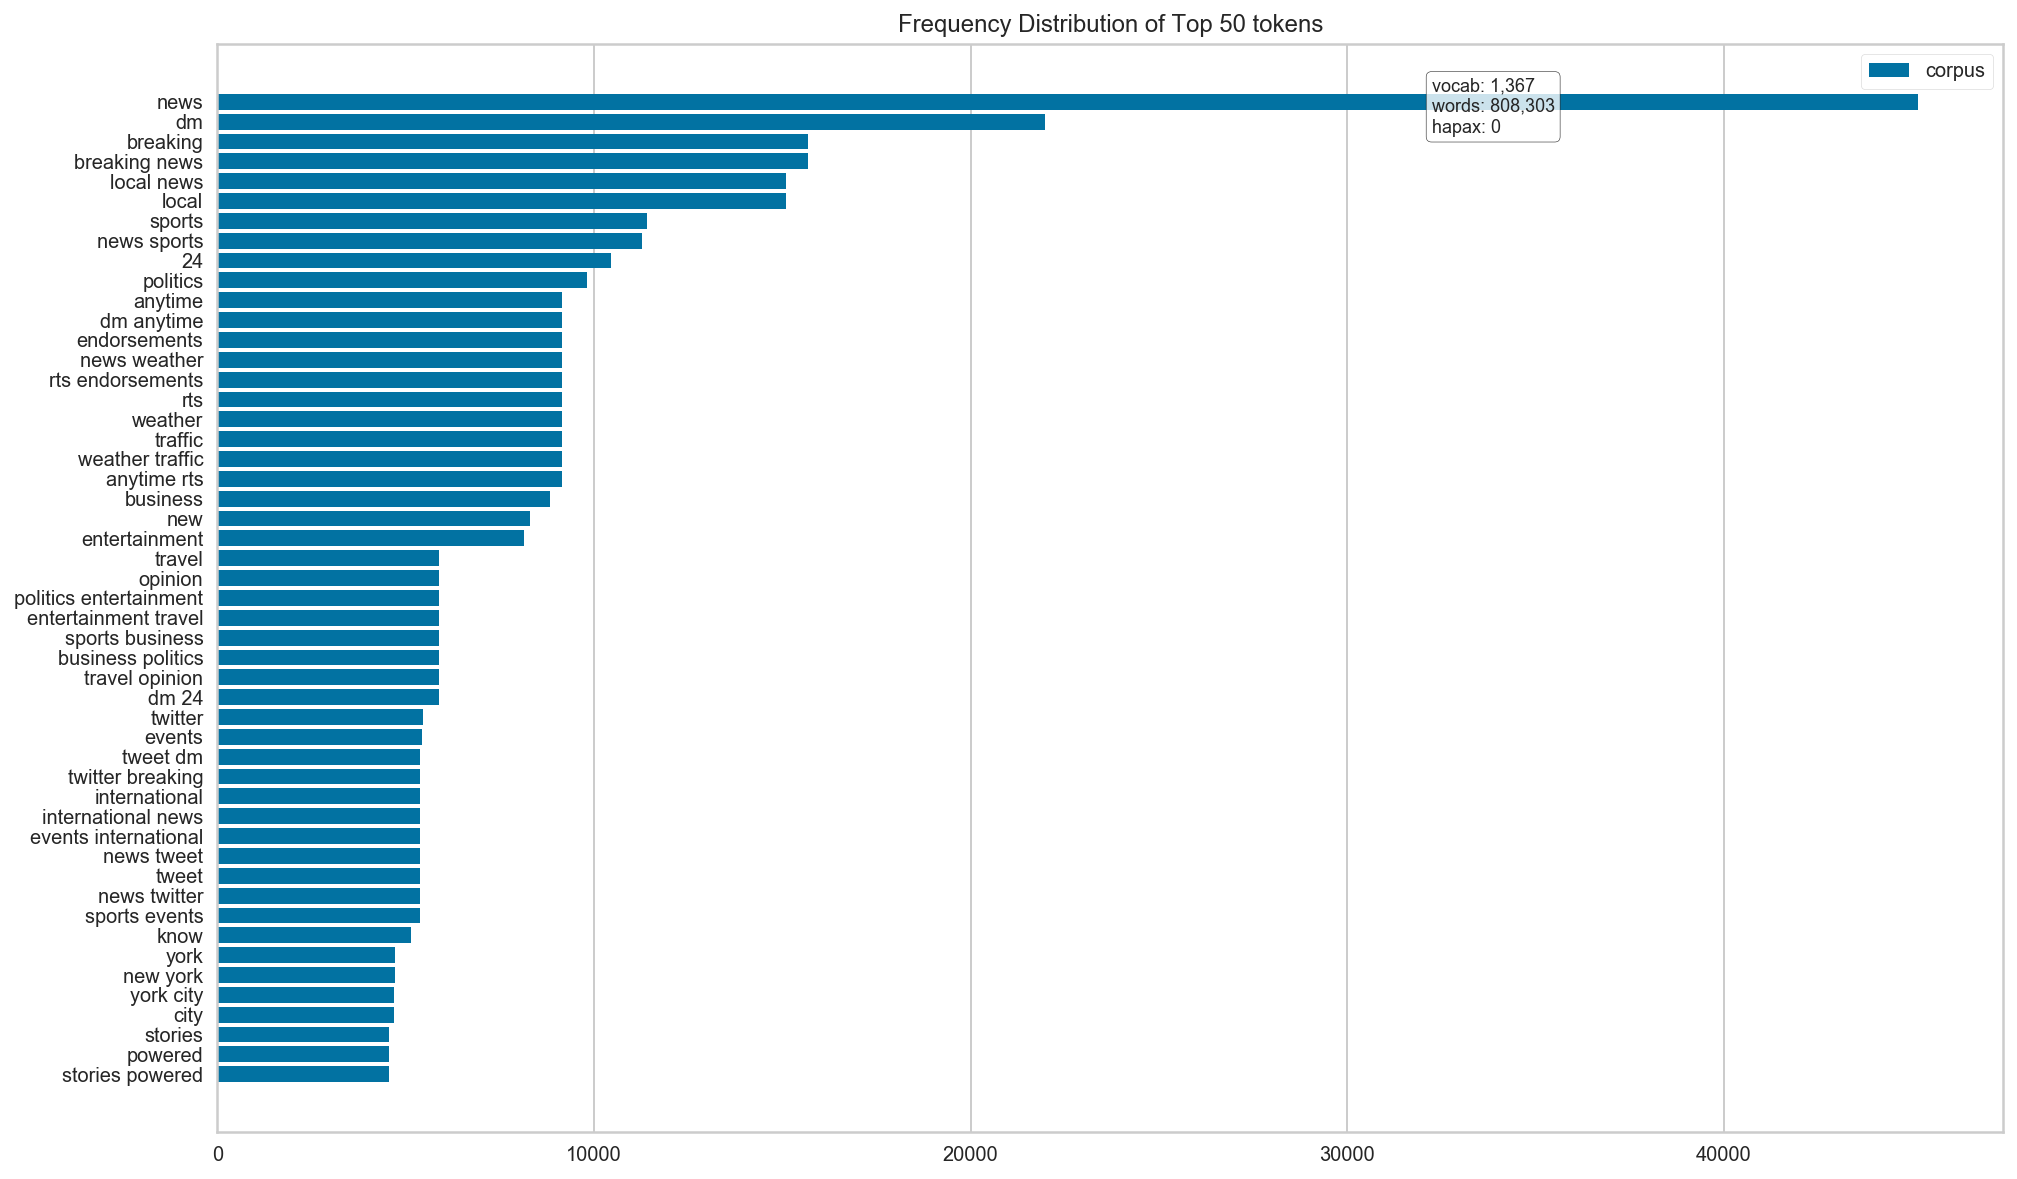

In [42]:
plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

### Chart 11A (ABOVE): Top 50 words used in user-profiles of state-backed accounts. 

### Chart 11B (BELOW): Top 50 words used in user-profiles of real accounts. 

In [43]:
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(real['user_profile_description'].dropna())
features = vect.get_feature_names()

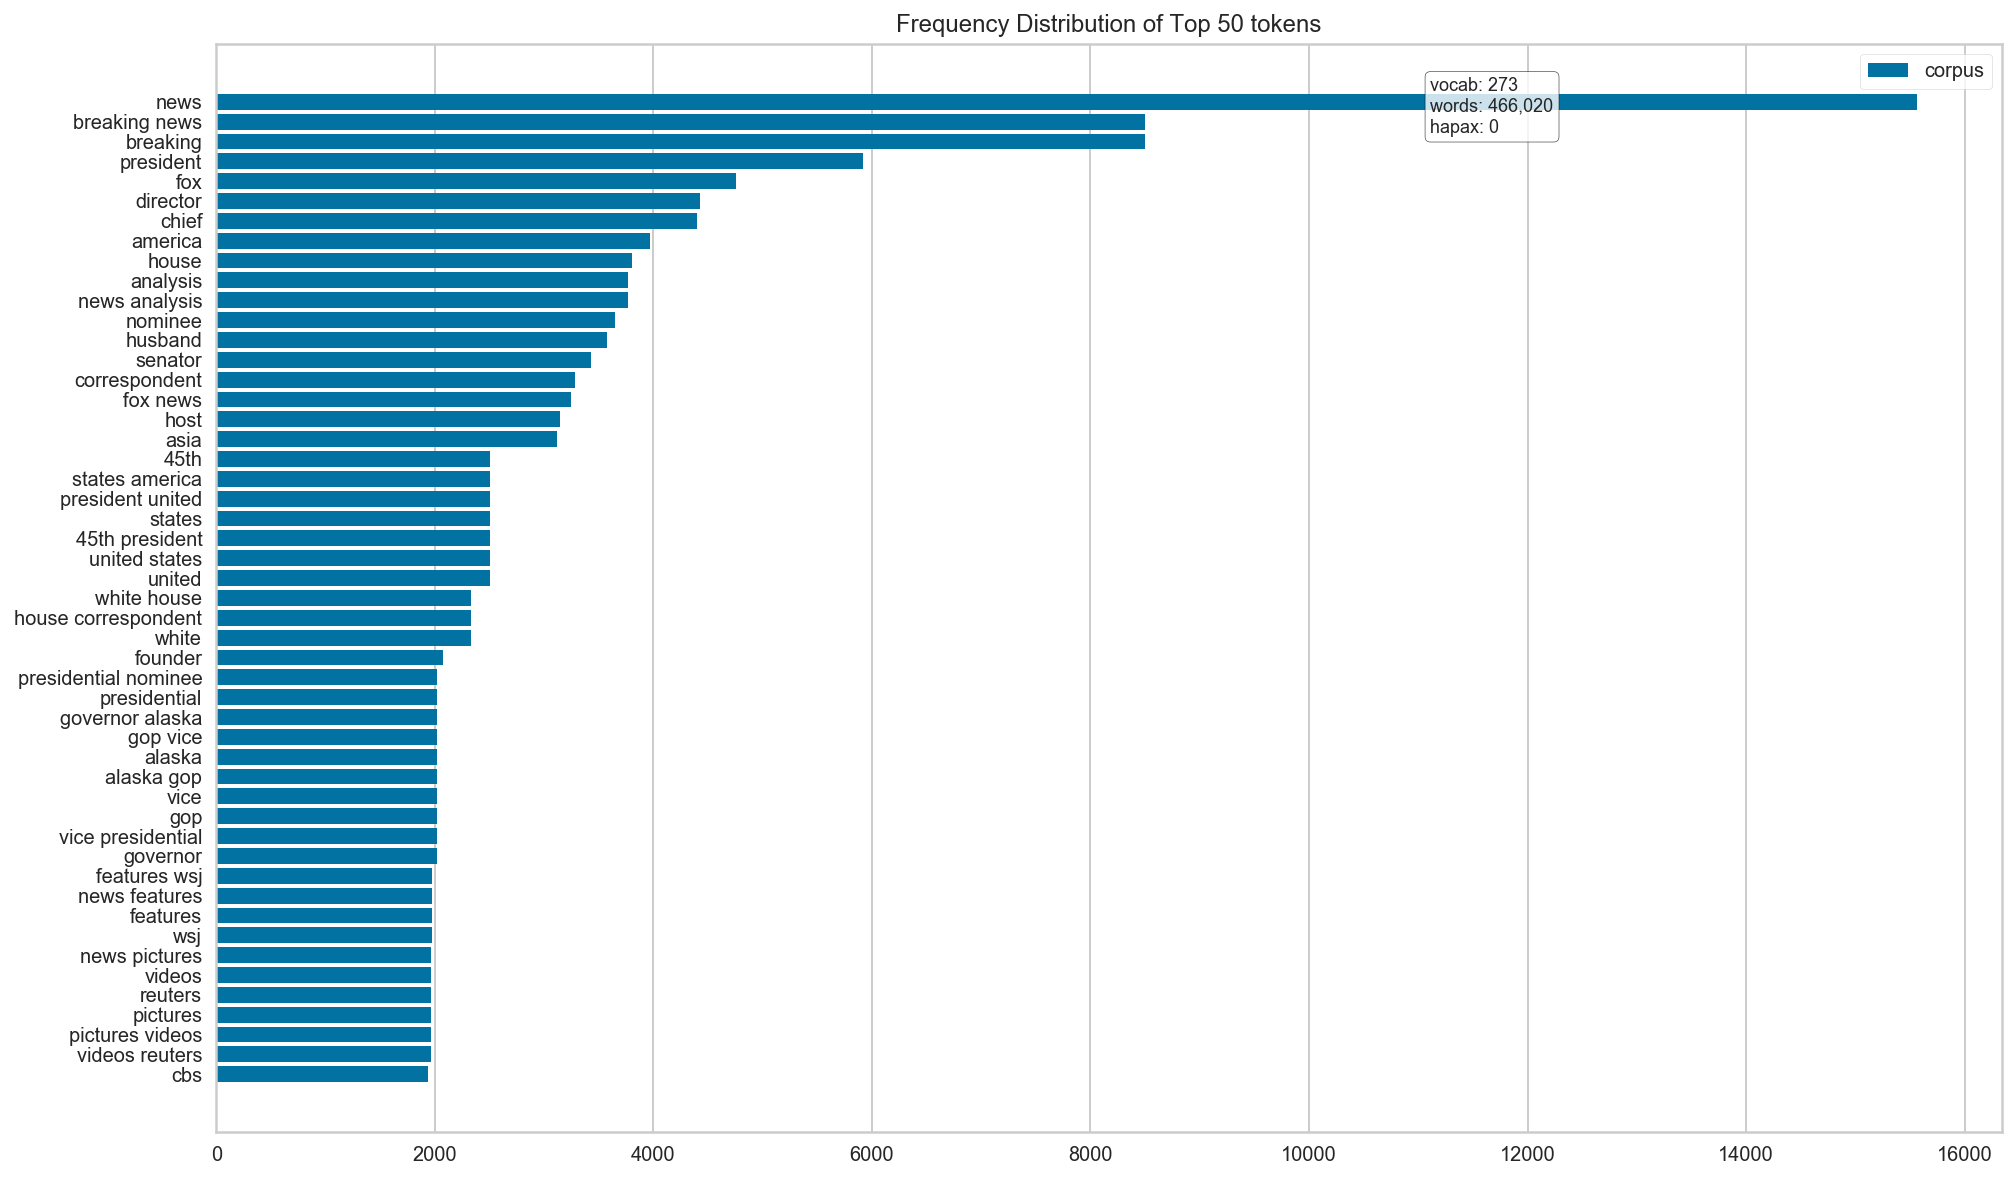

In [44]:
plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

### The similarities in the top 5 most frequently used terms in user profiles is striking - and reinforces the earlier observation that state-backed accounts are disguising themselves as news outlets, or as a source of news.

## 3.3 TOPIC MODELLING
It's not realistic to run the entire set of state-backed tweets through the different topic modelling options, so let's focus on the top 10 state-backed accounts instead. I've picked the state-backed accounts with the largest number of followers.

In [45]:
state_sample = state[
    (state["user_screen_name"] == "Pamela_Moore13")
    | (state["user_screen_name"] == "wokeluisa")
    | (state["user_screen_name"] == "USA_Gunslinger")
    | (state["user_screen_name"] == "TodayNYCity")
    | (state["user_screen_name"] == "SouthLoneStar")
    | (state["user_screen_name"] == "TheFoundingSon")
    | (state["user_screen_name"] == "WashingonOnline")
    | (state["user_screen_name"] == "BlackNewsOutlet")
    | (state["user_screen_name"] == "Politweecs")
    | (state["user_screen_name"] == "NewOrleansON")
    
]

## 3.3.1 t_SNE CORPUS VISUALISATION
t-SNE, or t-distributed stochastic neighbor embedding, is popularly used to cluster and visualise similar documents. In this notebook, I'm using the Yellowbrick library to visualise the topics in 11031 tweets the top 10 state-backed accounts in my dataset.

In [46]:
state_clean = state_sample['clean_tweet_text']
corpus = list(state_clean.values)

In [47]:
# There are 11,031 tweets in this sample
len(corpus)

11031

In [48]:
tfidf = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = tfidf.fit_transform(corpus)

In [49]:
# Let's see if the topic clusters are distinct enough for 10
clusters = KMeans(n_clusters=10)
clusters.fit(docs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

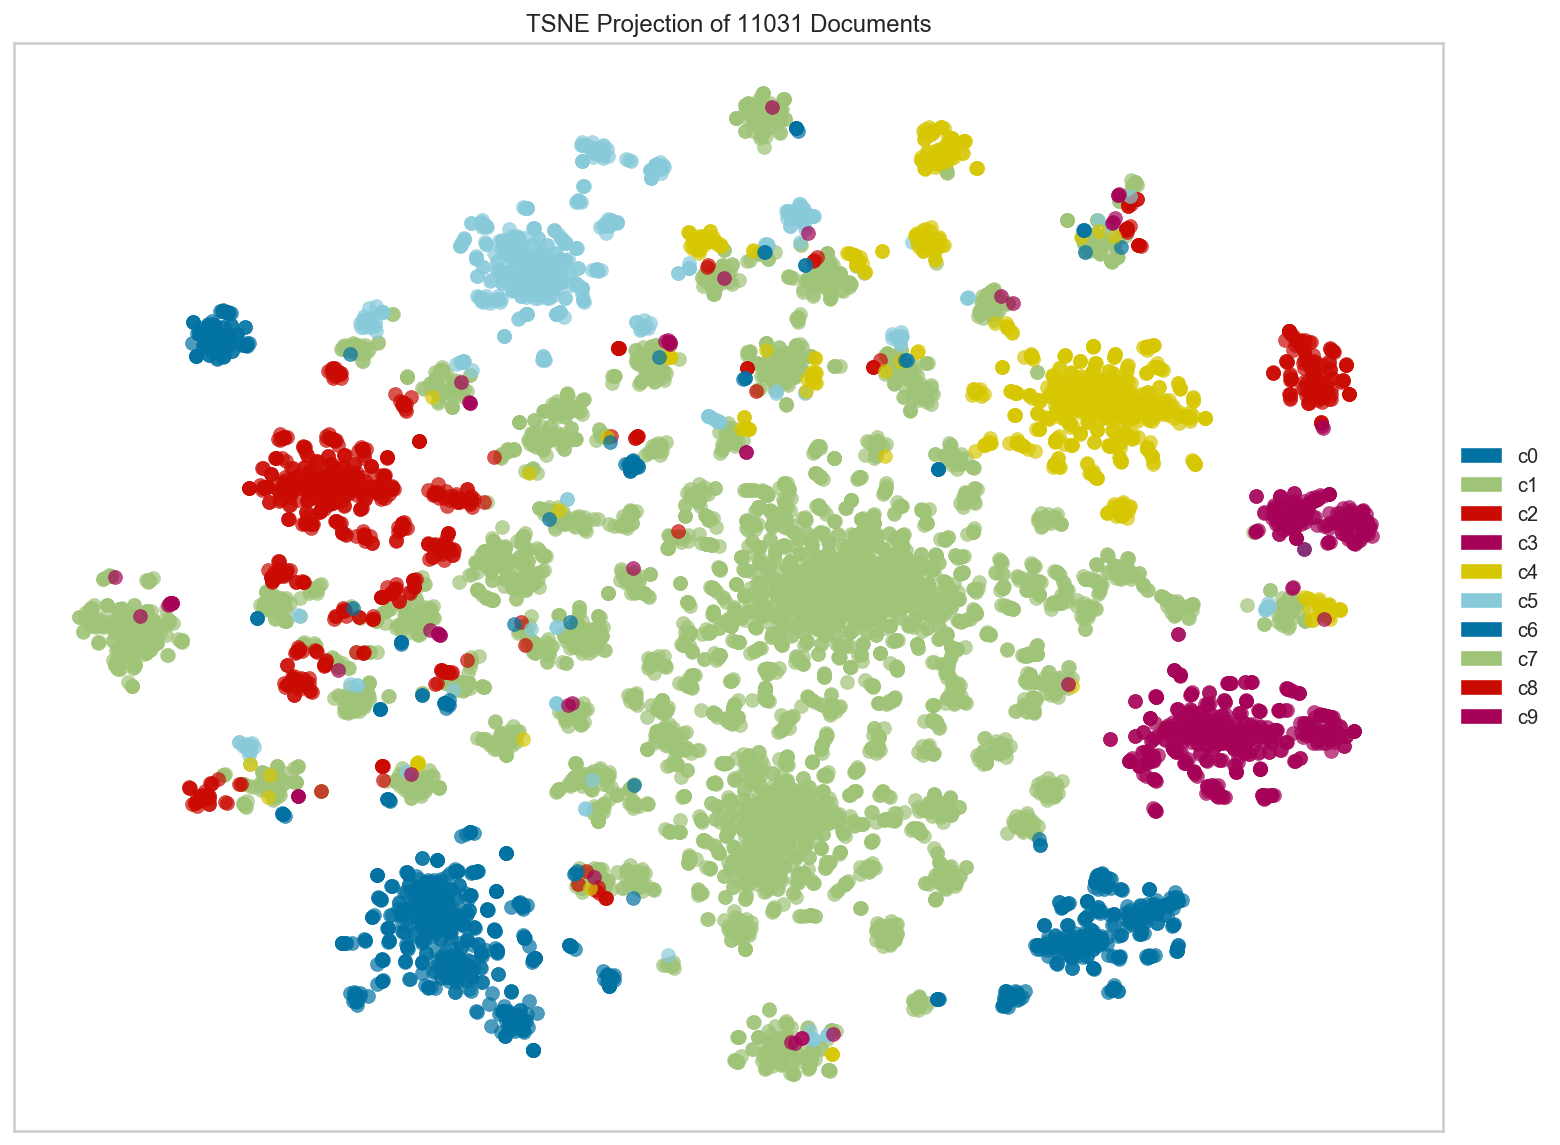

In [50]:
# This takes a while to re-run
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()
plt.show()

### CHART 12A: t-SNE TOPIC CLUSTERS FOR TOP 10 STATE-BACKED ACCOUNTS

As expected, there are clear clusters of topics in the tweets by the top 10 state-backed operators. There appears to be about 5 major clusters.

Let's see what the topic clusters look like for real users. In this instance, I'm not picking the accounts of the politicians like Trump or Obama, as their activity on Twitter is sometimes taken over by staffers.

In [51]:
real_sample = real[
    (real["user_screen_name"] == "jaketapper")
    | (real["user_screen_name"] == "prchovanec")
    | (real["user_screen_name"] == "dandrezner")
    | (real["user_screen_name"] == "maggieNYT")
    | (real["user_screen_name"] == "ariannahuff")
    | (state["user_screen_name"] == "markknoller")
    | (real["user_screen_name"] == "ezraklein")
    | (real["user_screen_name"] == "karaswisher")
    | (real["user_screen_name"] == "gtconway3d")
    | (real["user_screen_name"] == "BonnieGlaser")
    
]

In [52]:
real_clean = real_sample['clean_tweet_text']
corpus_clean = list(real_clean.values)

In [53]:
tfidf = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs_clean = tfidf.fit_transform(corpus_clean)

In [54]:
clusters = KMeans(n_clusters=10)
clusters.fit(docs_clean)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

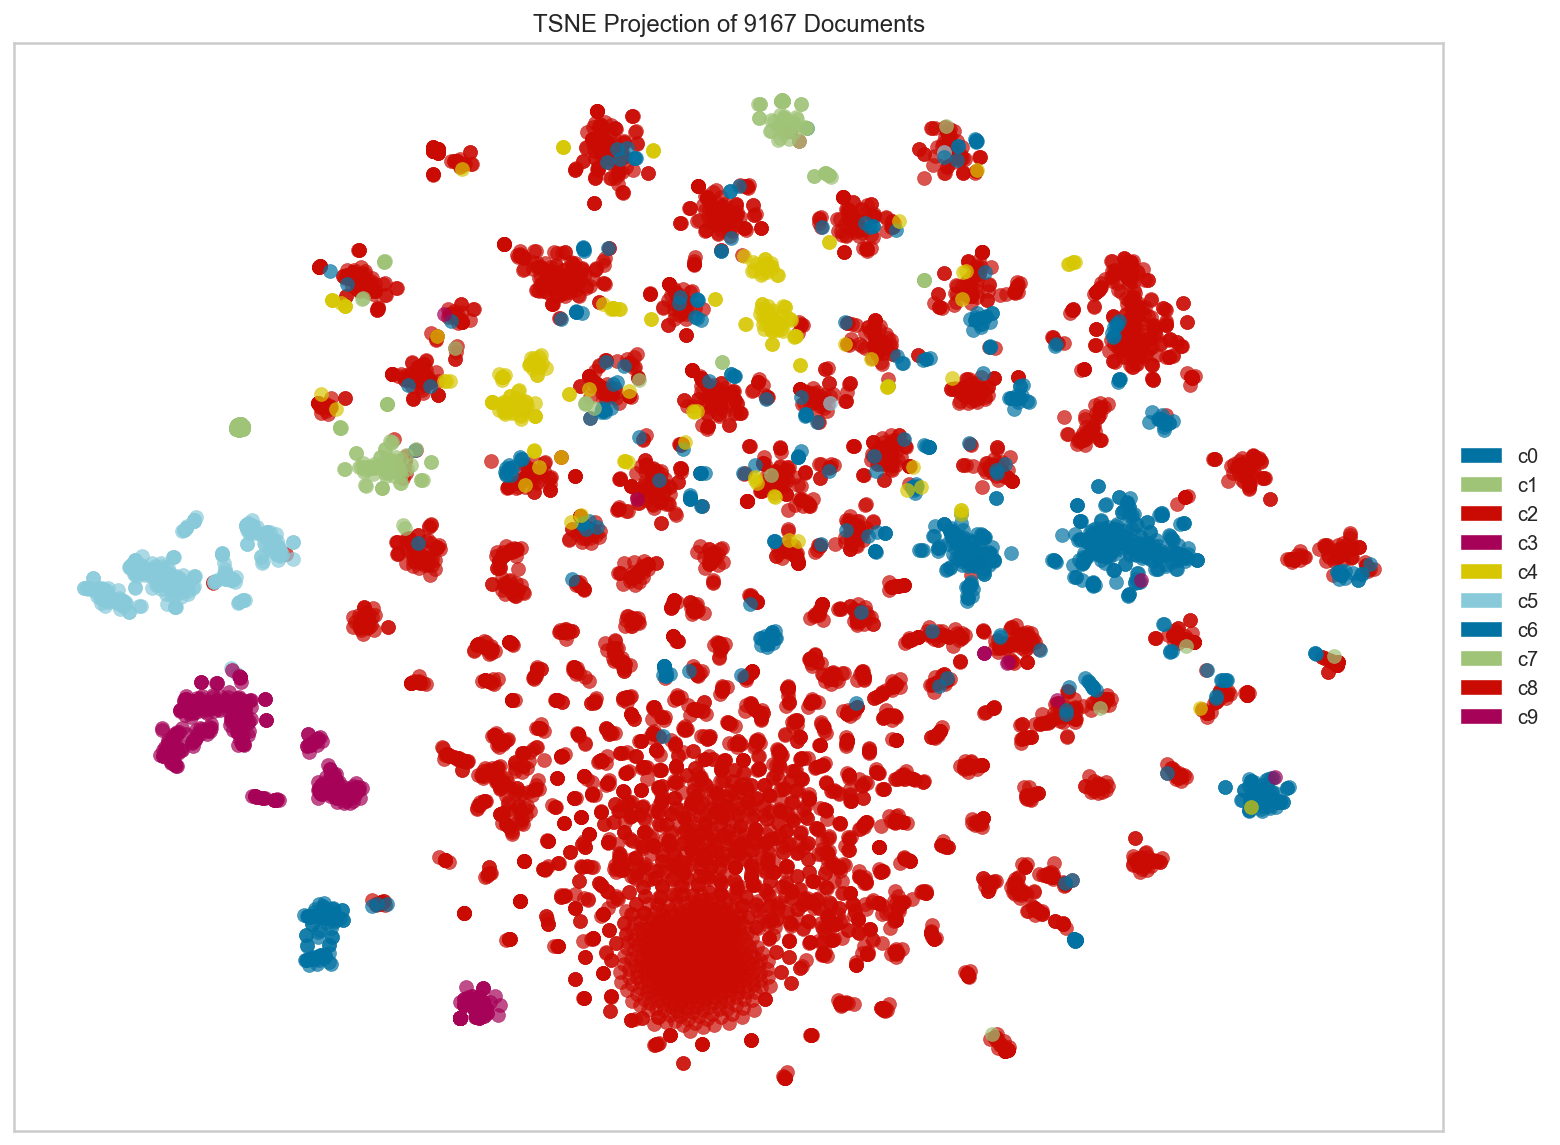

In [55]:
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs_clean, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()
plt.show()

### CHART 12B: t-SNE TOPIC CLUSTERS FOR 10 REAL ACCOUNTS

### ANALYSIS:
It is clear from charts 12A and 12B that the state-backed and real tweets are clustered differently, reflecting different user behavior and intent. But since the sample is unlabelled text, it's hard to tell what "c0" or "c9" refers to. 

For a clearer look, let's try another another popular tool for topic models, the pyLDAvis.

## 3.3.2 pyLDAvis

pyLDAvis is an interactive visualisation tool for interpreting topics. It extracts information from a fitted Latent Dirichlet allocation topic model to create the interactive tool.

In [56]:
# some additional pre-processing is needed, so I'll use the original tweet-text column from the sample instead
state_sample_text = state_sample['tweet_text']

In [57]:
state_text = list(state_sample_text.values)

In [58]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [59]:
def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join([ch for ch in stop_free if ch not in exclude])
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [60]:
text_clean = [clean(doc).split() for doc in state_text]
dictionary = corpora.Dictionary(text_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_clean] 

In [61]:
# I'm keeping the number of topics small so that they would be easier to discern
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = 5, id2word = dictionary, passes=100)

In [62]:
tfidf = models.TfidfModel(doc_term_matrix)
doc_tfidf = tfidf[doc_term_matrix]
doc_lda = ldamodel[doc_tfidf]

In [63]:
pyLDAvis.enable_notebook()

In [64]:
panel = pyLDAvis.gensim.prepare(ldamodel, doc_lda, dictionary, mds='tsne', sort_topics=True)
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
2     -31.169651  -72.246193       1        1  59.889732
0      45.892345  -85.414383       2        1  10.038956
1      10.506992  -54.465145       3        1  10.024066
4      12.040255 -115.734245       4        1  10.023788
3     -33.269871 -119.211540       5        1  10.023462, topic_info=     Category        Freq       Term       Total  loglift  logprob
12    Default  351.000000       news  351.000000  30.0000  30.0000
185   Default   73.000000    showbiz   73.000000  29.0000  29.0000
59    Default   34.000000        new   34.000000  28.0000  28.0000
134   Default   60.000000      trump   60.000000  27.0000  27.0000
40    Default   35.000000    newyork   35.000000  26.0000  26.0000
60    Default   18.000000    orleans   18.000000  25.0000  25.0000
104   Default   78.000000   politics   78.000000  24.0000  24.0000
11    Default   64.000000        lsu   64.000000  23.0000  23.0000
248   Default   16.000000        man   16.000000  22.0000  22.0000
581   Default   12.000000    science   12.000000  21.0000  21.0000
62    Default   33.000000     report   33.000000  20.0000  20.0000
95    Default   21.000000    hillary   21.000000  19.0000  19.0000
937   Default   11.000000     health   11.000000  18.0000  18.0000
269   Default   38.000000        say   38.000000  17.0000  17.0000
157   Default   11.000000      house   11.000000  16.0000  16.0000
191   Default  106.000000      sport  106.000000  15.0000  15.0000
452   Default    9.000000     police    9.000000  14.0000  14.0000
548   Default   13.000000      woman   13.000000  13.0000  13.0000
400   Default    7.000000      saint    7.000000  12.0000  12.0000
413   Default   11.000000        cop   11.000000  11.0000  11.0000
489   Default   23.000000          u   23.000000  10.0000  10.0000
103   Default   22.000000      obama   22.000000   9.0000   9.0000
702   Default   11.000000       vote   11.000000   8.0000   8.0000
351   Default    6.000000         de    6.000000   7.0000   7.0000
506   Default    6.000000       york    6.000000   6.0000   6.0000
439   Default   20.000000       2015   20.000000   5.0000   5.0000
161   Default    8.000000      white    8.000000   4.0000   4.0000
497   Default    7.000000       city    7.000000   3.0000   3.0000
35    Default    7.000000   brooklyn    7.000000   2.0000   2.0000
205   Default    5.000000   shooting    5.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
448    Topic5    1.317776     gunman    1.403773   2.2370  -6.7323
262    Topic5    1.310039      armed    1.396390   2.2364  -6.7382
1343   Topic5    1.289974  apartment    1.376647   2.2352  -6.7536
1006   Topic5    1.292974    roundup    1.381540   2.2340  -6.7513
3274   Topic5    1.248611    supreme    1.335127   2.2332  -6.7862
1688   Topic5    1.217477    missing    1.303755   2.2318  -6.8114
449    Topic5    1.190239     harlem    1.276346   2.2304  -6.8341
3180   Topic5    1.180592       body    1.267079   2.2295  -6.8422
1526   Topic5    3.441177        car    3.753578   2.2133  -5.7724
452    Topic5    7.820187     police    9.381360   2.1182  -4.9515
497    Topic5    6.008590       city    7.365697   2.0966  -5.2150
1630   Topic5    2.646677    charged    3.027100   2.1659  -6.0349
248    Topic5   12.367627        man   16.848072   1.9911  -4.4931
1000   Topic5    2.492695      crash    2.848812   2.1667  -6.0948
851    Topic5    2.837895      found    3.313929   2.1452  -5.9652
35     Topic5    5.898546   brooklyn    7.552493   2.0531  -5.2335
505    Topic5    3.479841         st    4.193229   2.1138  -5.7612
1001   Topic5    3.472912       dead    4.361206   2.0725  -5.7632
40     Topic5   19.098654    newyork   35.145092   1.6904  -4.0586
530    Topic5    2.878765    officer    3.620888   2.0709  -5.9509
402    Topic5    2.294252          v    2.875136   2.0745  -6.1778
12     

### CHART 13A (ABOVE): VISUALISING TOPIC MODELS FOR TWEETS FROM TOP 10 STATE-BACKED ACCOUNTS

### HOW THE VISUALISATION TOOL WORKS:
Here are official [instructions](http://www.kennyshirley.com/LDAvis/):

- click a circle in the left panel to select a topic, and the bar chart in the right panel will display the 30 most relevant terms for the selected topic.

- The red bars represent the frequency of a term in a given topic, and the blue bars represent a term's frequency across the entire corpus.

- Change the value of λ to adjust the term rankings -- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic. 

Now let's look at a similar interactive chart for the real users.

In [65]:
real_sample_text = real_sample['tweet_text']
real_text = list(state_sample_text.values)

In [66]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [67]:
real_clean = [clean(doc).split() for doc in real_text]
dictionary_clean = corpora.Dictionary(real_clean)
dtm_real = [dictionary_clean.doc2bow(doc) for doc in real_clean] 

In [68]:
Lda_real = gensim.models.ldamodel.LdaModel
ldamodel_real = Lda_real(dtm_real, num_topics = 5, id2word = dictionary, passes=100)

In [69]:
tfidf_real = models.TfidfModel(dtm_real)
doc_tfidf_real = tfidf_real[dtm_real]
doc_lda_real = ldamodel[doc_tfidf_real]

In [70]:
panel_real = pyLDAvis.gensim.prepare(ldamodel_real, doc_lda_real, dictionary_clean, mds='tsne', sort_topics=True)
panel_real

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      89.454582 -12.479129       1        1  57.125736
3      55.674179 -16.393738       2        1  12.788332
1      21.895927 -20.308516       3        1  10.029147
2      51.759682  17.384111       4        1  10.028409
4      59.589458 -50.174480       5        1  10.028376, topic_info=     Category        Freq       Term       Total  loglift  logprob
12    Default  344.000000       news  344.000000  30.0000  30.0000
59    Default  175.000000        new  175.000000  29.0000  29.0000
191   Default  155.000000      sport  155.000000  28.0000  28.0000
134   Default   43.000000      trump   43.000000  27.0000  27.0000
40    Default   44.000000    newyork   44.000000  26.0000  26.0000
104   Default   33.000000   politics   33.000000  25.0000  25.0000
60    Default   83.000000    orleans   83.000000  24.0000  24.0000
248   Default   23.000000        man   23.000000  23.0000  23.0000
185   Default   47.000000    showbiz   47.000000  22.0000  22.0000
413   Default   15.000000        cop   15.000000  21.0000  21.0000
35    Default   11.000000   brooklyn   11.000000  20.0000  20.0000
506   Default   44.000000       york   44.000000  19.0000  19.0000
11    Default   51.000000        lsu   51.000000  18.0000  18.0000
400   Default   46.000000      saint   46.000000  17.0000  17.0000
62    Default   21.000000     report   21.000000  16.0000  16.0000
548   Default   16.000000      woman   16.000000  15.0000  15.0000
269   Default   44.000000        say   44.000000  14.0000  14.0000
351   Default    8.000000         de    8.000000  13.0000  13.0000
430   Default   12.000000      court   12.000000  12.0000  12.0000
788   Default    7.000000  president    7.000000  11.0000  11.0000
755   Default    7.000000    clinton    7.000000  10.0000  10.0000
103   Default    8.000000      obama    8.000000   9.0000   9.0000
452   Default   13.000000     police   13.000000   8.0000   8.0000
157   Default   11.000000      house   11.000000   7.0000   7.0000
868   Default    6.000000     blasio    6.000000   6.0000   6.0000
439   Default   21.000000       2015   21.000000   5.0000   5.0000
230   Default    6.000000       fire    6.000000   4.0000   4.0000
192   Default   31.000000        win   31.000000   3.0000   3.0000
88    Default   25.000000       game   25.000000   2.0000   2.0000
1053  Default    5.000000        gop    5.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
3520   Topic5    1.321873        bar    1.403761   2.2396  -6.7297
935    Topic5    3.115874       star    3.613115   2.1517  -5.8722
3174   Topic5    2.231199     second    2.508780   2.1825  -6.2062
205    Topic5    5.188884   shooting    7.315710   1.9562  -5.3622
12     Topic5   67.665642       news  344.635498   0.6718  -2.7941
185    Topic5   13.912072    showbiz   47.860546   1.0642  -4.3760
31     Topic5    2.992184    suspect    5.101730   1.7662  -5.9127
2197   Topic5    2.163947     public    3.016345   1.9676  -6.2368
62     Topic5    6.480653     report   21.754454   1.0888  -5.1399
2921   Topic5    1.721389        tom    2.063011   2.1187  -6.4656
248    Topic5    6.074460        man   23.319035   0.9546  -5.2046
956    Topic5    3.336420  louisiana    8.038387   1.4204  -5.8038
59     Topic5   13.510615        new  175.402649  -0.2639  -4.4052
1187   Topic5    2.815338        gun    5.875175   1.5641  -5.9736
206    Topic5    2.850878     street    6.316223   1.5043  -5.9611
60     Topic5    8.855438    orleans   83.536095   0.0555  -4.8277
937    Topic5    3.987749     health   14.610765   1.0012  -5.6255
269    Topic5    5.805258        say   44.290642   0.2677  -5.2499
452    Topic5    3.520828     police   13.475079   0.9576  -5.7500
22     Topic5    2.470615         tv    5.535149   1.4931  -6.1042
454    Topic5    2.529083       shot    7.062617   1.2728  -6.0809
685    Topic5 

### CHART 13B (ABOVE): VISUALISING TOPIC MODELS FOR TWEETS FROM 10 REAL ACCOUNTS

### ANALYSIS:
Again, it seems strange at first sight how similar these two charts are. Why should "news" and "sport" and "newyork" dominate so highly on the most salient terms in the topic clusters?

But the charts totally make sense when seen in the context of what we've seen in earlier charts - that is, the state-backed accounts are trying to disguise themselves as a news outlet, or source of innocuous information for sports or entertainment. These trolls work not by blatantly blasting pro-Trump tweets 24/7, but by mixing disinformation with real news so users would be less susceptible.

## 3.3.3 QUINTIESSENTIAL STATE TWEETS 
Based on what we now know, let's look at a collection of quintiessential state-backed tweets by Russian trolls.

In [71]:
state_tweets_news = state[state['tweet_text'].str.contains('news')]

In [72]:
state_tweets_news['tweet_text'].sample(n=5, random_state=42).values

array(['AP PHOTOS: Legacies of a disaster dot Japan’s tsunami coast https://t.co/SOxSepG83g #news',
       'Seguin woman upset after investigator opens car for front page story #news https://t.co/rewPyqJEGJ https://t.co/fFeXkago1z',
       'Johnson County man fatally shot in the street during domestic fight  #crime #news',
       'Poll: tea party support drops to new lows  #news',
       "Madison sheriff responds to Jackson councilman's remarks  #news"],
      dtype=object)

In [73]:
state_tweets_sports = state[state['tweet_text'].str.contains('sport')]

In [74]:
state_tweets_sports['tweet_text'].sample(n=5, random_state=42).values

array(['Florida, South Carolina visit 5-star Rummel CB Kristian Fulton on same night  #sports',
       'Nationals 4, Mets 3: With Door to Important Win Open, Mets Hit a Wall  #sports',
       'Jackson: Tigers need to reduce miscues  #sports',
       'Report slams cycling body on anti-doping  #sports',
       'Sterling boys knock off La Marque, advance to state final  #sports'],
      dtype=object)

### From these two sets of tweets, we can see exactly how the state-backed trolls are covering their tracks by tweeting innocuous stuff which a potential real user might actually send out on Twitter. Now let's look at the more politically driven tweets that hint at the real goals of the trolls' influence campaigns. 

In [75]:
state_tweets_trump = state[state['tweet_text'].str.contains('trump')]

In [76]:
state_tweets_trump['tweet_text'].sample(n=10, random_state=42).values

array(['#LeftistTerror Funny how quickly they switch from "love trumps hate" to calls for killing someone they don\'t like https://t.co/T8bpBXroTr',
       'So is Donald trump saying Obama did a poor job at office because he was black...that comment he made disgusted me @DeeAyEmii @_ThatsTayy',
       '@murph7041 ...so enjoy 8 years of president trump and 30+ years of trump agenda !',
       '.@infotrump2020 At least @Carrier products will be made in USA in the next coming days...  Trump will restore energy jobs (oil), which (1)',
       '#SorosAgenda is what undermining American democracy. Not trump or Trump supporters have done anything close to what this man is doing https://t.co/R602sxQwS3',
       '@UTHornsRawk @Cameron0047 @trumpingtheleft @CohenTisha @ltapoll @blessenkat @DonWulfy718 @TEN_GOP @GartrellLinda @NetworksManager @kitten_nc https://t.co/yfyTPHt655',
       'In 2015 recap, Mitch Landrieu says Confederate monuments never trumped public safety  #politics',
       'Donald

In [77]:
state_tweets_hillary = state[state['tweet_text'].str.contains('hillary')]

In [78]:
state_tweets_hillary['tweet_text'].sample(n=10, random_state=42).values

array(["For #hillaryclinton , email no longer a joking matter. Yes it's really going to be a very serious problem for her. http://t.co/TaRWXDLj8o",
       '#HillaryClinton #HillaryForPrison2016 #HillaryIndictment #hillaryisevil #TrumpPence16 https://t.co/WzdHVQQU2n #TrumpForPresident',
       '#PresentsTrumpGot notice from hillary',
       '#Hillary, please, just one spoon... #hillary4prison2016 https://t.co/xmqs2IA914',
       'She’d better spend her time and money on her healthcare and leave the politics forever. #collapsinghillary https://t.co/EluDNAbn4S',
       "I'm sick right now😡😡 Paid Hillary thugs beat up a homeless woman when she was defending Trump's star in Hollywood. #hillarysemail https://t.co/jrNbY8IA2X",
       'DEM VOTER FRAUD: The only way they can win is to steal it #hillarysemail https://t.co/goUSf5hbSu',
       'Is there a true reason why Hillary Clinton stands against the Second Amendment? #2a #hillary #beingpatriotic https://t.co/VP9qyN3hD3',
       'HILLARY CLIN

### The sharp difference in tone and political leaning in both sets of political tweets are telling, with the state-backed trolls clearly spreading disinformation such as "paid Hillary thugs beat up a homeless woman", and inciting opposition against her with hashtags like "#hillaryisevil".

## 4. DIGITAL FINGERPRINT OF A RUSSIAN STATE-BACKED TROLL

Here's what we know so far about a typical Russian state-backed account and its tweets - its digital fingerprints, so to speak:

- Account likely created in 2014, with the months of May and August being the most popular.

- Very low follower-to-following ratio, even for accounts with large number of followers. The nature of its operations require the trolls to follow a disproportionately large number of real accounts in order to magnify its impact.

- More likely to use hashtags instead of URLs, which real users prefer.

- Shorter tweets with fewer characters (less than 70) and fewer number of words (11 to 14 or less).

- Self-reported locations: Likely similar to the one where the audience it is trying to influence is based. So one tell-tale sign would be a sudden spike in the number of new-user signups professing to be from the same country.

- Hiding in plain sight: The state-backed accounts disguise themselves by mimicking the content that real users favour in a particular location. These trolls are sophisticated, and work by mixing pieces of disinformation alongside those that might interest real users. In the case of the US, large number of real Twitter users go to the platform for news, politics and sports updates. And that's what the state operators have tried to exploit.

Obviously these characteristics don't define *all* state-backed trolls, who clearly will and are adjusting their tactics all the time to avoid detection. But they will always leave a digital fingerprint, and to the extent that you can find one by using some of the steps above, you can build a clear profile of their online behavior.